In [17]:
#!pip install git+https://github.com/ahwillia/tensortools

In [4]:
#pip install umap-learn

Author: Nick Ponvert

In [134]:
!date

Thu Mar  4 22:39:14 PST 2021


# TCA on GLM results
After performing the dropout analysis for the VBA ophys GLM project, we have multiple dropout scores for each neuron, on each session where the neuron was recorded. We also can track some neurons over multiple sessions in each container. We therefore have, for many neurons, a (n_cells * n_dropout_scores * n_sessions) data tensor. We can take advantage of tools for tensor decomposition to model the data using a smaller set of tensor components. We can then look at relationships between the components, assess which groups of cells group into which sets of factors, and look at how different factors change over each session.

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import visual_behavior_glm
import visual_behavior_glm.GLM_params as glm_params
import visual_behavior_glm.GLM_analysis_tools as gat

import visual_behavior.data_access.loading as loading
import tensortools

In [2]:
from sklearn.cluster import DBSCAN

In [5]:
import umap

In [6]:
class ContainerTCA(object):
    def __init__(self, container_id, rspm, features, tca_rank=5):
        '''
        Class for performing TCA decomposition on data from one container.
        
        Args:
            container_id: The ID of the container we want to analyze
            rspm: The full cell * dropout_param matrix of scores from the 
                  glm_analysis_tools.build_pivoted_results_summary() func.
            features: Which dropout score columns to use from the rspm dataframe
            tca_rank: The rank of the decomposition we want to perform.
        '''
        self.container_id = container_id
        self.rspm = rspm
        self.features = features
        self.tca_rank = tca_rank
        self.container_pd = self.get_container_pd()
        self.session_inds = self.get_session_inds()
        self.session_names = self.get_session_names()
        self.container_xr = self.get_container_xr()
        self.cells_in_all_sessions_arr = self.get_cells_in_all_sessions_arr()
        self.U = self.get_tca_decomposition()
        self.colors = self.get_colors_for_session_numbers()
        
    def get_container_pd(self):
        container_id = self.container_id
        container_pd = rspm.query('container_id==@container_id')
        return container_pd
    
    def get_session_inds(self):
        session_inds = self.container_pd[
            ['ophys_session_id', 'session_number']
        ].drop_duplicates()['session_number'].values - 1
        session_inds = session_inds.astype(int)
        return session_inds
    
    def get_session_names(self):
        session_names = self.container_pd[
            ['ophys_session_id', 'session_number', 'session_type']
        ].drop_duplicates()['session_type'].values
        return session_names
    
    def get_container_xr(self):
        container_xr = (
            pd.melt(self.container_pd, value_vars=self.features, id_vars=['cell_specimen_id', 'ophys_session_id'])
            .set_index(['cell_specimen_id', 'variable', 'ophys_session_id'])
            .fillna(0)
            .to_xarray()
            .transpose('cell_specimen_id', 'variable', 'ophys_session_id')
         )
        return container_xr
        
    def get_cells_in_all_sessions_arr(self):
        
        container_arr = self.container_xr['value'].data
        cells_present_all_sessions = np.logical_not(np.isnan(container_arr)).any(axis=1).all(axis=1)
        cells_in_all_sessions_arr = container_arr[cells_present_all_sessions, :, :]

        # The dropout scores are nearly always negative, so we can flip them and take
        # advantage of nonnegative TCA
        cells_in_all_sessions_arr *= -1
        
        return cells_in_all_sessions_arr
    
    def get_tca_decomposition(self):
        U = tensortools.ncp_hals(self.cells_in_all_sessions_arr, rank=self.tca_rank)
        return U
    
    @staticmethod 
    def argsort_cells(U, ind_rank=0):
        '''
        Get a sorting order for the cell factors based off the cell weights for a particular rank.
        '''
        cell_weights = U.factors.factors[0][:, ind_rank]
        return np.argsort(cell_weights)
    
    @staticmethod
    def get_colors_for_session_numbers():
        reds = sns.color_palette('Reds_r', 6)[:5][::2]
        blues = sns.color_palette('Blues_r', 6)[:5][::2]
        return reds+blues
    
    def container_tca_plot(self, sorting_ind_rank=0, cluster_labels=None, savedir=None):
        
        # Sort cells by cluster, or by one of the factors if no cluster labels supplied
        if cluster_labels is None:
            sorting_order = self.argsort_cells(self.U, sorting_ind_rank)
            bar_color = '0.2'
        else:
            sorting_order = np.argsort(cluster_labels)
            color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
            bar_color = [color_cycle[i] for i in cluster_labels[sorting_order]]
        
        num_factors = len(self.U.factors.factors)
        num_components = self.U.factors.rank
        fig, axes = plt.subplots(num_components, num_factors);
        fig.set_size_inches(15, 15)

        for ind_rank in range(num_components):

            # Plot cell factors, sorted
            cell_ax = axes[ind_rank, 0]
            cell_fac = self.U.factors.factors[0][:, ind_rank]
            cell_ax.bar(x=np.arange(len(cell_fac)), 
                        height=cell_fac[sorting_order],
                       color=bar_color)

            # Plot PSTH factors, sorted
            param_ax = axes[ind_rank, 1]
            param_fac = self.U.factors.factors[1][:, ind_rank]
            param_ax.plot(-1*param_fac, '-o', color='0.2')

            param_ax.set_xticks(range(len(param_fac)))
            param_ax.set_xticklabels([''] * len(param_fac))
            param_ax.axhline(y=0, color='0.5', ls='--')

            trial_ax = axes[ind_rank, 2]
            trial_fac = self.U.factors.factors[2][:, ind_rank]
            trial_ax.plot(trial_fac, 'k-')
            for ind_trial in range(len(trial_fac)):
                trial_ax.plot(ind_trial, trial_fac[ind_trial], 'o',
                         color=self.colors[self.session_inds[ind_trial]], ms=8)
            trial_ax.set_xticks(range(len(trial_fac)))
            trial_ax.set_xticklabels([''] * len(trial_fac))
            sns.despine()

        axes[-1, 0].set_xlabel('cell factor', fontsize=14)
        axes[-1, 1].set_xlabel('dropout score factor', fontsize=14)
        axes[-1, 1].set_xticklabels(self.features, rotation=60, ha='right')
        axes[-1, 2].set_xlabel('session factor', fontsize=14)
        axes[-1, 2].set_xticklabels(self.session_names, rotation=60, ha='right')

        plt.suptitle(f"Container: {self.container_id}")
        plt.subplots_adjust(hspace=0.1)
        
        if savedir is not None:
            plt.savefig(os.path.join(savedir, f"container_{self.container_id}.png"))
            
            
    def two_factor_correlation_plot(self, factor_inds_to_compare=[0, 1]):
        
        if (not isinstance(factor_inds_to_compare, list)) or (len(factor_inds_to_compare) != 2):
            raise ValueError('Needs a 2-item list with factor inds to compare')
        
        fac_0_label = f"factor {factor_inds_to_compare[0]}"
        fac_1_label = f"factor {factor_inds_to_compare[1]}"
        data_0 = tca.U.factors.factors[0][:, factor_inds_to_compare[0]]
        data_1 = tca.U.factors.factors[0][:, factor_inds_to_compare[1]]
        data = pd.DataFrame({fac_0_label: data_0, fac_1_label: data_1})
        slope, intercept, r_val, p_val, err = stats.linregress(data_0, data_1)
        sns.lmplot(
            x=fac_0_label, y=fac_1_label, data=data
        )
        plt.title(f'r**2={r_val**2:.2}, p={p_val:.2}')
        
    def get_factor_df(self, factor='cell'):
        if factor not in ['cell', 'param', 'session']:
            raise ValueError('Factors for this decomposition are: cell, param, session')
        factor_inds = {
            'cell':0,
            'param': 1,
            'session': 2
        }
        data = pd.DataFrame(
            {f"factor_{i}": tca.U.factors.factors[factor_inds[factor]][:, i] for i in range(self.tca_rank)}
        )
        return data
    
    def all_cell_factor_correlation_plot(self):
        data = self.get_factor_df(factor='cell')
        sns.pairplot(data=data, corner=True)

# Load experiment table

In [7]:
experiments_table = loading.get_filtered_ophys_experiment_table()

In [8]:
experiments_table.head()

,ophys_session_id,behavior_session_id,container_id,project_code,container_workflow_state,experiment_workflow_state,session_name,session_type,equipment_name,date_of_acquisition,...,super_container_id,cre_line,session_tags,failure_tags,prior_exposures_to_session_type,prior_exposures_to_image_set,prior_exposures_to_omissions,model_outputs_available,location,session_number
ophys_experiment_id,,,,,,,,,,,,,,,,,,,,,
951980471,951410079,951520319,1018028342,VisualBehaviorMultiscope,published,passed,20190920_457841_1imagesA_2,OPHYS_1_images_A,MESO.1,2019-09-20 09:45:29.897856,...,850862430,Sst-IRES-Cre,NaN,NaN,0,65.0,0.0,False,Sst_VISp_150,1
951980475,951410079,951520319,1018028339,VisualBehaviorMultiscope,published,passed,20190920_457841_1imagesA_2,OPHYS_1_images_A,MESO.1,2019-09-20 09:45:29.897856,...,850862430,Sst-IRES-Cre,NaN,NaN,0,65.0,0.0,False,Sst_VISp_75,1
951980486,951410079,951520319,1018028360,VisualBehaviorMultiscope,published,passed,20190920_457841_1imagesA_2,OPHYS_1_images_A,MESO.1,2019-09-20 09:45:29.897856,...,850862430,Sst-IRES-Cre,NaN,NaN,0,65.0,0.0,False,Sst_VISl_300,1
951980479,951410079,951520319,1018028354,VisualBehaviorMultiscope,published,passed,20190920_457841_1imagesA_2,OPHYS_1_images_A,MESO.1,2019-09-20 09:45:29.897856,...,850862430,Sst-IRES-Cre,NaN,NaN,0,65.0,0.0,False,Sst_VISl_150,1
951980481,951410079,951520319,1018028357,VisualBehaviorMultiscope,published,passed,20190920_457841_1imagesA_2,OPHYS_1_images_A,MESO.1,2019-09-20 09:45:29.897856,...,850862430,Sst-IRES-Cre,NaN,NaN,0,65.0,0.0,False,Sst_VISl_225,1


# Get results for glm version 9a

In [9]:
model_output_type = 'adj_fraction_change_from_full'
glm_version = '9a_L2_optimize_by_session'

In [10]:
rspm = gat.build_pivoted_results_summary(value_to_use=model_output_type, results_summary=None, 
                                       glm_version=glm_version, cutoff=0.01)

In [11]:
rspm.head()

,identifier,Full,all-images,beh_model,behavioral,cognitive,correct_rejects,expectation,face_motion_PC_0,face_motion_PC_1,...,super_container_id,cre_line,session_tags,failure_tags,prior_exposures_to_session_type,prior_exposures_to_image_set,prior_exposures_to_omissions,model_outputs_available,location,session_number
0,1000743008_1003146172,0.0,-0.131169,-0.003489,-0.251514,-0.025145,-0.009547,-0.057581,-0.053424,-0.005941,...,951667115.0,Sst-IRES-Cre,NaN,NaN,0.0,32.0,1.0,True,Sst_VISp_275,1.0
1,1000743008_1003146180,0.0,-0.172658,0.000000,0.000000,-0.006048,0.000000,-0.066927,0.000000,0.000000,...,951667115.0,Sst-IRES-Cre,NaN,NaN,0.0,32.0,1.0,True,Sst_VISp_275,1.0
2,1000743008_1003146183,0.0,-0.256476,0.000000,-0.136978,-0.011285,0.000000,-0.046704,-0.016123,0.000000,...,951667115.0,Sst-IRES-Cre,NaN,NaN,0.0,32.0,1.0,True,Sst_VISp_275,1.0
3,1000743008_1003146186,0.0,-0.413599,0.000000,0.000000,0.000000,0.000000,-0.040592,-0.000053,0.000000,...,951667115.0,Sst-IRES-Cre,NaN,NaN,0.0,32.0,1.0,True,Sst_VISp_275,1.0
4,1000743008_1003146190,0.0,-0.097979,-0.001260,-0.053031,-0.013947,0.000000,-0.053520,-0.036129,0.000000,...,951667115.0,Sst-IRES-Cre,NaN,NaN,0.0,32.0,1.0,True,Sst_VISp_275,1.0


In [12]:
rspm['cre_line'].unique()

array(['Sst-IRES-Cre', nan, 'Vip-IRES-Cre', 'Slc17a7-IRES2-Cre',
       'Slc17a7-IRES2-Cre;Ai94'], dtype=object)

In [13]:
features_to_plot = [
 'visual',
 'all-images',
 'omissions',
 'behavioral',
 'licking',
 'licks',
 'pupil',
 'running',
 'face_motion_energy',
 'face_motion_PC_0',
 'face_motion_PC_1',
 'face_motion_PC_2',
 'face_motion_PC_3',
 'face_motion_PC_4',
 'cognitive',
 'image_expectation',
 'hits',
 'misses',
 'false_alarms',
 'correct_rejects',
 'intercept',
 'beh_model',
 'model_bias',
 'model_omissions1',
 'model_task0',
 'model_timing1D',
 'task',
 'time',
 ]

level_up_features = [
'visual',
'all-images',
'omissions',
'behavioral',
'task',
'beh_model',
 ]

clustering_features = [
    'all-images',
    'omissions',
    'behavioral',
    'licking',
    'pupil',
    'running',
    'face_motion_PC_0',
    'face_motion_PC_1'
]

# Containers ranked by average number of cells

In [14]:
sst_containers_sorted_by_average_number_of_cells = (
    rspm.query("cre_line=='Sst-IRES-Cre'")
    .groupby(['container_id', 'ophys_experiment_id'])['cell_specimen_id']
    .count()
    .reset_index()
    .groupby('container_id')['cell_specimen_id']
    .mean()
    .sort_values(ascending=False)
)

slc_containers_sorted_by_average_number_of_cells = (
    rspm.query("cre_line=='Slc17a7-IRES2-Cre'")
    .groupby(['container_id', 'ophys_experiment_id'])['cell_specimen_id']
    .count()
    .reset_index()
    .groupby('container_id')['cell_specimen_id']
    .mean()
    .sort_values(ascending=False)
)

vip_containers_sorted_by_average_number_of_cells = (
    rspm.query("cre_line=='Vip-IRES-Cre'")
    .groupby(['container_id', 'ophys_experiment_id'])['cell_specimen_id']
    .count()
    .reset_index()
    .groupby('container_id')['cell_specimen_id']
    .mean()
    .sort_values(ascending=False)
)

In [15]:
sst_containers_sorted_by_average_number_of_cells.head()

container_id
1.018028e+09    19.600000
1.018028e+09    17.000000
1.018028e+09    16.000000
9.413735e+08    15.666667
1.018028e+09    15.000000
Name: cell_specimen_id, dtype: float64

In [16]:
slc_containers_sorted_by_average_number_of_cells

container_id
8.462131e+08    230.000000
1.018028e+09    230.000000
8.147966e+08    197.500000
8.035894e+08    194.000000
1.018028e+09    189.500000
                   ...    
1.018028e+09     10.333333
9.300223e+08      9.500000
1.018028e+09      8.166667
1.018028e+09      5.166667
1.037673e+09      1.666667
Name: cell_specimen_id, Length: 117, dtype: float64

In [17]:
vip_containers_sorted_by_average_number_of_cells

container_id
1.022732e+09    28.833333
7.913524e+08    28.000000
1.018028e+09    25.000000
1.022732e+09    25.000000
1.022732e+09    25.000000
                  ...    
1.018028e+09     4.000000
1.018028e+09     3.777778
1.000740e+09     3.500000
1.018028e+09     3.500000
9.283252e+08     2.800000
Name: cell_specimen_id, Length: 80, dtype: float64

# Example container workflow

In [18]:
experiments_table.query('container_id==876693136')

,ophys_session_id,behavior_session_id,container_id,project_code,container_workflow_state,experiment_workflow_state,session_name,session_type,equipment_name,date_of_acquisition,...,super_container_id,cre_line,session_tags,failure_tags,prior_exposures_to_session_type,prior_exposures_to_image_set,prior_exposures_to_omissions,model_outputs_available,location,session_number
ophys_experiment_id,,,,,,,,,,,,,,,,,,,,,
842975542,842752650,842812730,876693136,VisualBehavior,published,passed,20190328_442709_1imagesA,OPHYS_1_images_A,CAM2P.4,2019-03-28 18:03:12.000000,...,814111935,Slc17a7-IRES2-Cre;Ai94,NaN,NaN,1,12.0,1.0,True,Slc17a7_VISp_175,1
843520488,843363571,843401576,876693136,VisualBehavior,published,passed,20190329_442709_2imagesA,OPHYS_2_images_A_passive,CAM2P.4,2019-03-29 19:46:32.000000,...,814111935,Slc17a7-IRES2-Cre;Ai94,NaN,NaN,0,13.0,2.0,False,Slc17a7_VISp_175,2
844395446,843871375,844027599,876693136,VisualBehavior,published,passed,20190401_442709_3imagesA,OPHYS_3_images_A,CAM2P.4,2019-04-01 15:35:42.000000,...,814111935,Slc17a7-IRES2-Cre;Ai94,NaN,NaN,0,14.0,3.0,True,Slc17a7_VISp_175,3
845037476,844465368,844649493,876693136,VisualBehavior,published,passed,20190402_442709_4imagesB,OPHYS_4_images_B,CAM2P.4,2019-04-02 15:34:14.000000,...,814111935,Slc17a7-IRES2-Cre;Ai94,NaN,NaN,0,0.0,4.0,True,Slc17a7_VISp_175,4
846487947,845840207,846011320,876693136,VisualBehavior,published,passed,20190404_442709_6imagesB,OPHYS_6_images_B,CAM2P.4,2019-04-04 15:26:26.000000,...,814111935,Slc17a7-IRES2-Cre;Ai94,NaN,NaN,0,1.0,5.0,True,Slc17a7_VISp_175,6
847241639,846605051,846710859,876693136,VisualBehavior,published,passed,20190405_442709_5ImagesB,OPHYS_5_images_B_passive,CAM2P.4,2019-04-05 15:37:36.000000,...,814111935,Slc17a7-IRES2-Cre;Ai94,NaN,NaN,0,2.0,6.0,False,Slc17a7_VISp_175,5


In [19]:
#need a tensor n_cells X n_scores X n_sessions
container_id = 876693136
container_pd = rspm.query('container_id==@container_id')

/home/nick.ponvert/.local/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='ophys_session_id', ylabel='count'>

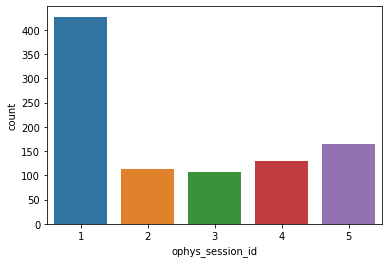

In [20]:
sns.countplot(container_pd.groupby('cell_specimen_id')['ophys_session_id'].count())

In [21]:
tca = ContainerTCA(container_id=container_id, rspm=rspm, features=clustering_features)

/home/nick.ponvert/.conda/envs/nick/lib/python3.7/site-packages/tensortools/optimize/ncp_hals.py:185: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
  Cp = factors[:, idx] @ grams[idx][:, p]
/home/nick.ponvert/.conda/envs/nick/lib/python3.7/site-packages/numba/core/typing/npydecl.py:930: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
  warnings.warn(NumbaPerformanceWarning(msg))


NCP_HALS: iteration 1, objective 0.4913232086281439, improvement inf.
NCP_HALS: iteration 2, objective 0.412115391560628, improvement 0.0792078170675159.
NCP_HALS: iteration 3, objective 0.3852623268697777, improvement 0.026853064690850303.
NCP_HALS: iteration 4, objective 0.37727665084479206, improvement 0.007985676024985622.
NCP_HALS: iteration 5, objective 0.37369698552559416, improvement 0.0035796653191979.
NCP_HALS: iteration 6, objective 0.3704871875830025, improvement 0.0032097979425916856.
NCP_HALS: iteration 7, objective 0.36713740371818787, improvement 0.003349783864814604.
NCP_HALS: iteration 8, objective 0.36363222588947386, improvement 0.0035051778287140123.
NCP_HALS: iteration 9, objective 0.3599316213822963, improvement 0.003700604507177574.
NCP_HALS: iteration 10, objective 0.355957525363532, improvement 0.003974096018764306.
NCP_HALS: iteration 11, objective 0.35358551366941265, improvement 0.0023720116941193248.
NCP_HALS: iteration 12, objective 0.3528291848472105, im

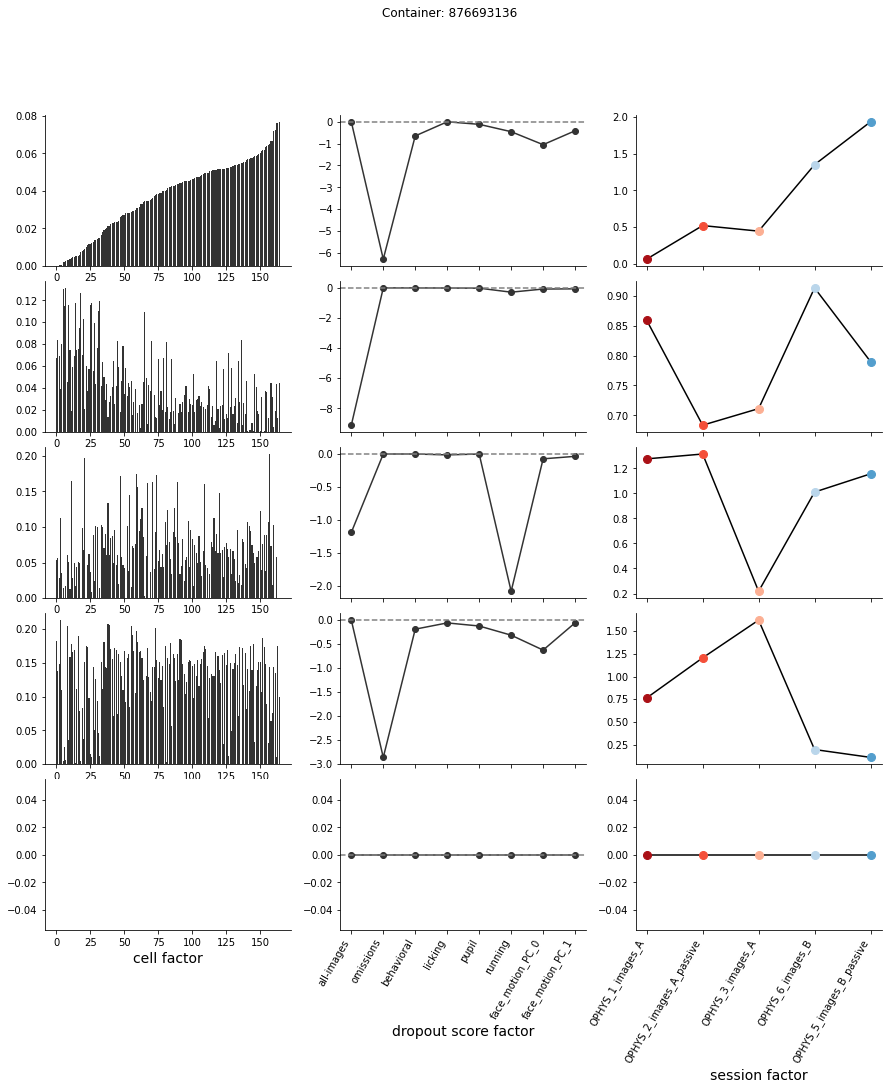

In [22]:
tca.container_tca_plot()

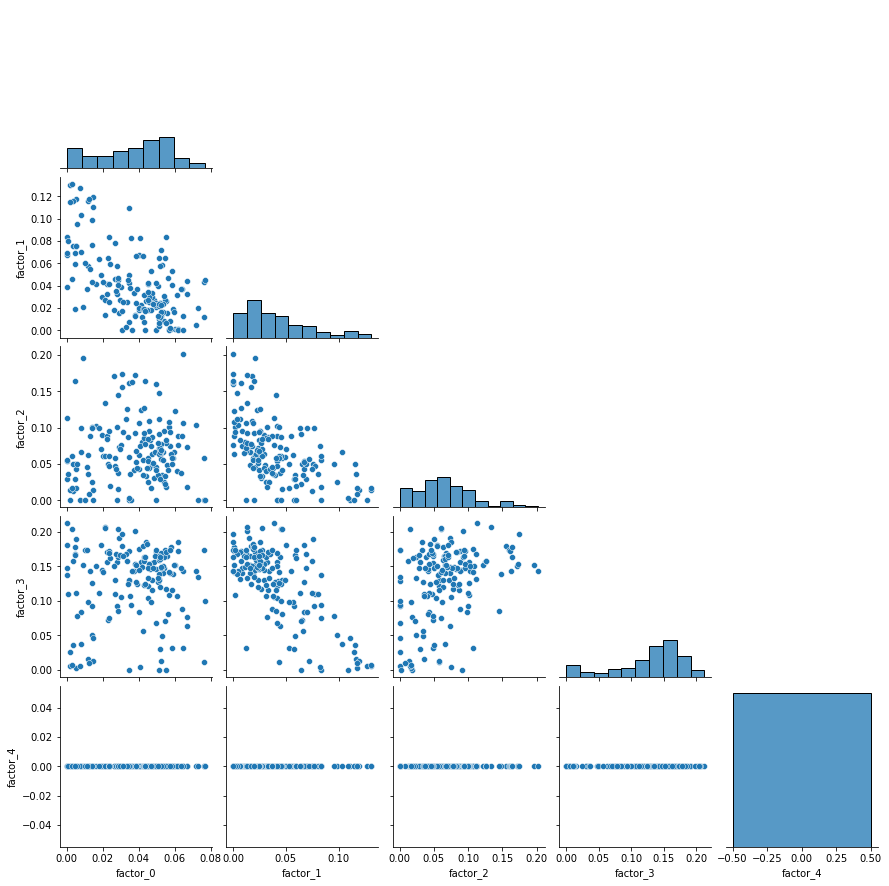

In [23]:
tca.all_cell_factor_correlation_plot()

In [24]:
reducer = umap.UMAP()
cell_fac_df = tca.get_factor_df(factor='cell')
embedding = reducer.fit_transform(cell_fac_df.values)
embedding.shape

/home/nick.ponvert/.conda/envs/nick/lib/python3.7/site-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


(165, 2)

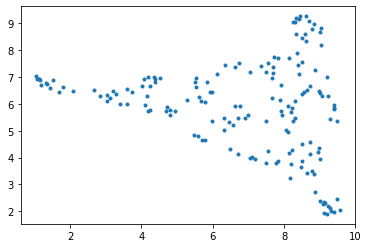

In [25]:
plt.plot(embedding[:, 0], embedding[:,1], '.')

In [26]:
clus = DBSCAN(eps=0.54, min_samples=5).fit(embedding)

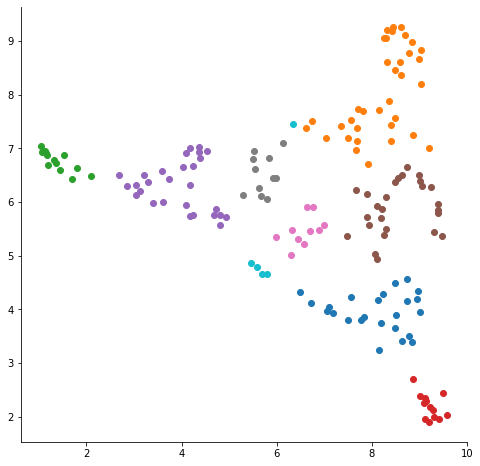

In [27]:
color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
for cluster_number in np.unique(clus.labels_):
    cluster_mask = clus.labels_ == cluster_number
    plt.plot(embedding[cluster_mask, 0], embedding[cluster_mask,1], '.', color=color_cycle[cluster_number], ms=12)
sns.despine()
plt.gcf().set_size_inches(8, 8)

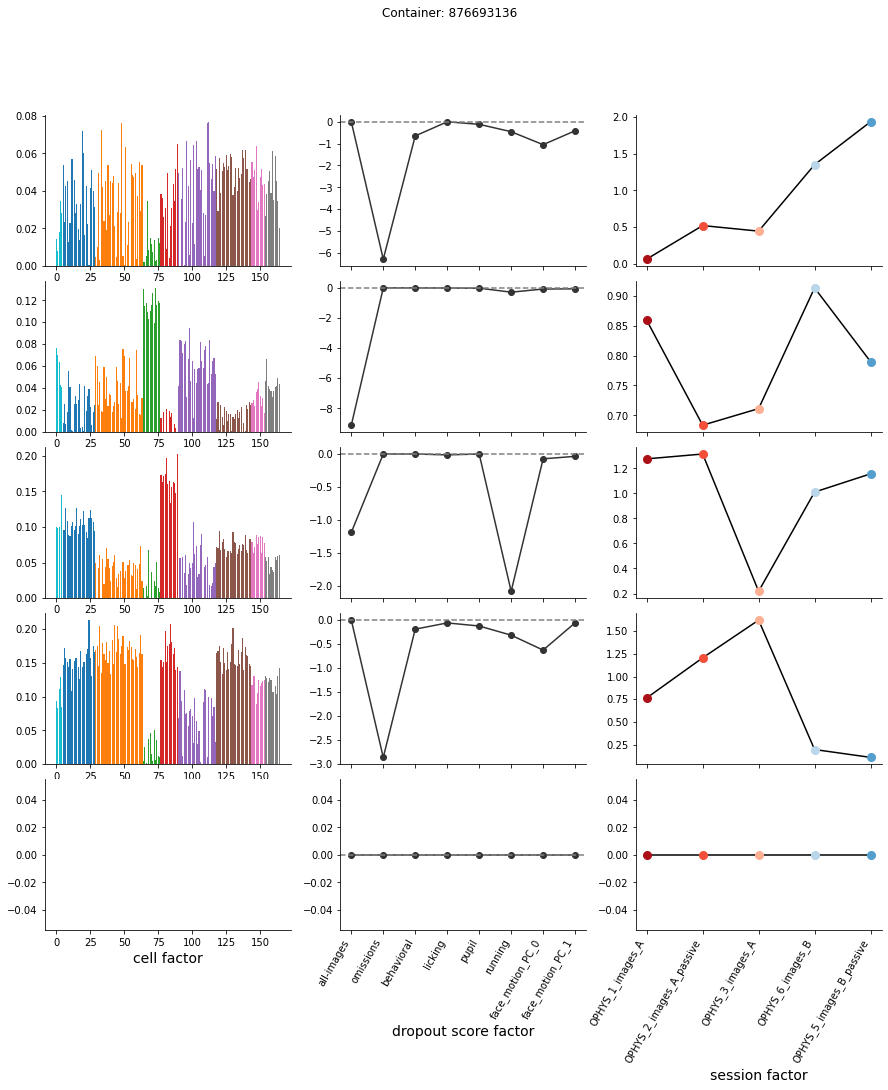

In [28]:
tca.container_tca_plot(cluster_labels=clus.labels_)

# Slc containers

In [29]:
container_id = slc_containers_sorted_by_average_number_of_cells.index[0]
container_id

846213087.0

In [30]:
tca = ContainerTCA(container_id=container_id, rspm=rspm, features=clustering_features)

NCP_HALS: iteration 1, objective 0.4937770003119586, improvement inf.
NCP_HALS: iteration 2, objective 0.38607177836700074, improvement 0.10770522194495785.
NCP_HALS: iteration 3, objective 0.35654798782846503, improvement 0.02952379053853571.
NCP_HALS: iteration 4, objective 0.34566514269749177, improvement 0.010882845130973262.
NCP_HALS: iteration 5, objective 0.3397161090941567, improvement 0.005949033603335041.
NCP_HALS: iteration 6, objective 0.33546253967959366, improvement 0.004253569414563063.
NCP_HALS: iteration 7, objective 0.3323321867372089, improvement 0.0031303529423847842.
NCP_HALS: iteration 8, objective 0.329770514534081, improvement 0.0025616722031278627.
NCP_HALS: iteration 9, objective 0.32777332264562303, improvement 0.001997191888457983.
NCP_HALS: iteration 10, objective 0.326561546459981, improvement 0.001211776185642055.
NCP_HALS: iteration 11, objective 0.32573954747664297, improvement 0.0008219989833380126.
NCP_HALS: iteration 12, objective 0.32507380629107996

In [31]:
reducer = umap.UMAP()
cell_fac_df = tca.get_factor_df(factor='cell')
embedding = reducer.fit_transform(cell_fac_df.values)
embedding.shape

(54, 2)

In [32]:
clus = DBSCAN(eps=0.54, min_samples=5).fit(embedding)

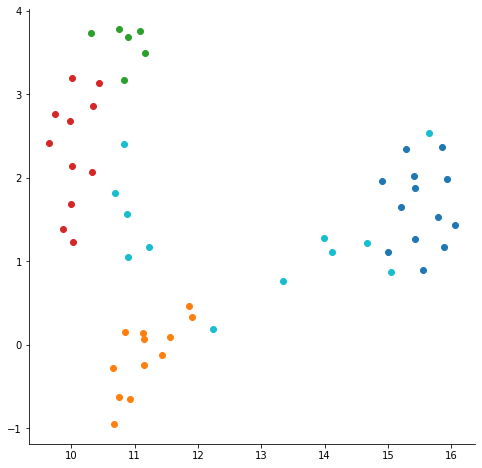

In [33]:
color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
for cluster_number in np.unique(clus.labels_):
    cluster_mask = clus.labels_ == cluster_number
    plt.plot(embedding[cluster_mask, 0], embedding[cluster_mask,1], '.', color=color_cycle[cluster_number], ms=12)
sns.despine()
plt.gcf().set_size_inches(8, 8)

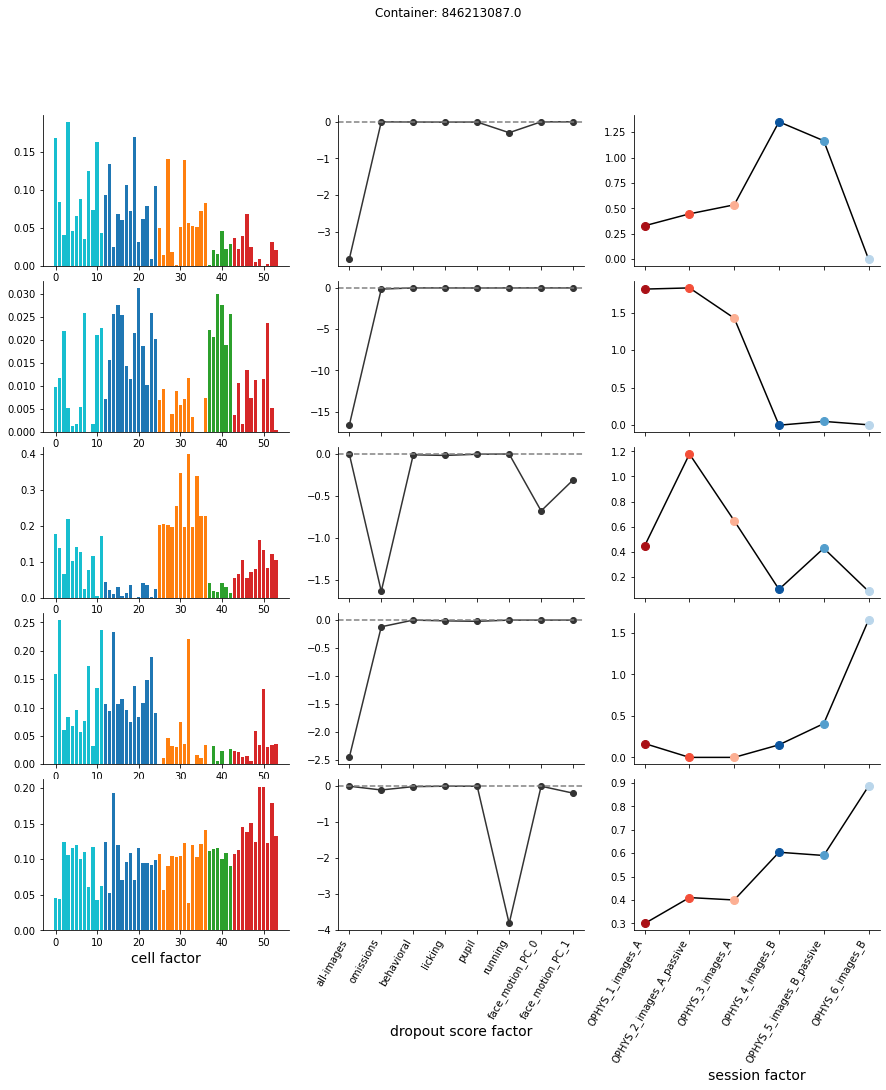

In [34]:
tca.container_tca_plot(cluster_labels=clus.labels_)

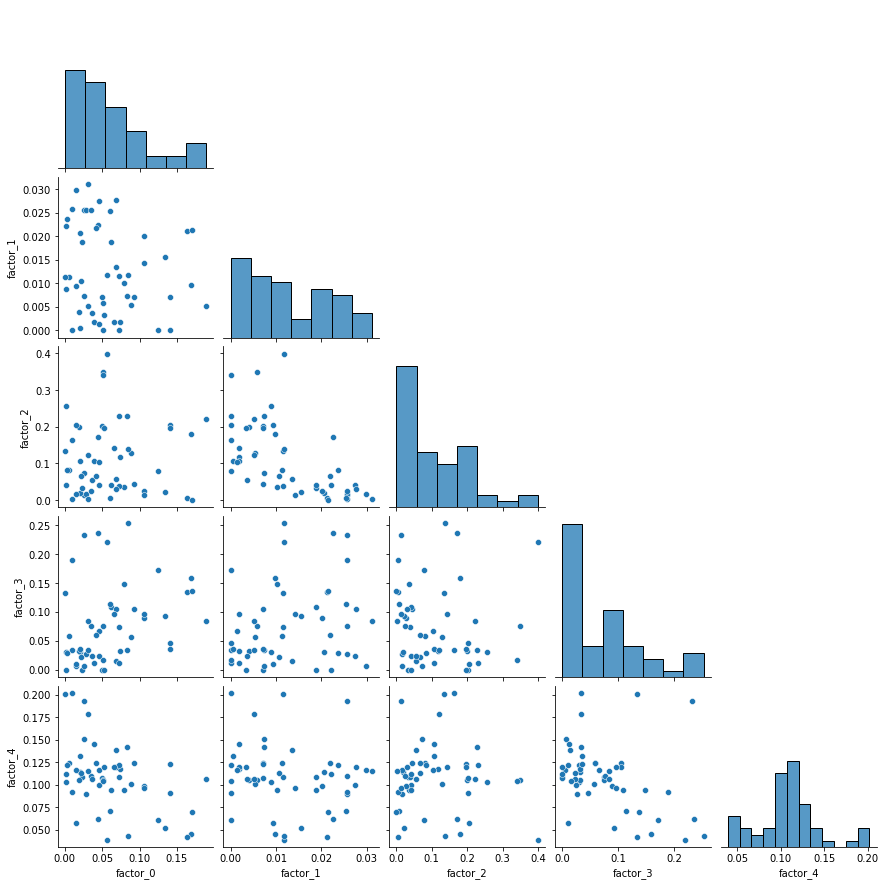

In [35]:
tca.all_cell_factor_correlation_plot()

---

In [36]:
container_id = slc_containers_sorted_by_average_number_of_cells.index[1]
container_id

1018027828.0

In [37]:
tca = ContainerTCA(container_id=container_id, rspm=rspm, features=clustering_features)

NCP_HALS: iteration 1, objective 0.5450302762759164, improvement inf.
NCP_HALS: iteration 2, objective 0.49669123956800143, improvement 0.04833903670791495.
NCP_HALS: iteration 3, objective 0.47560872290086914, improvement 0.02108251666713229.
NCP_HALS: iteration 4, objective 0.46178813503976307, improvement 0.01382058786110607.
NCP_HALS: iteration 5, objective 0.4533656470125934, improvement 0.008422488027169661.
NCP_HALS: iteration 6, objective 0.4490221015197662, improvement 0.004343545492827228.
NCP_HALS: iteration 7, objective 0.4461205975998303, improvement 0.002901503919935877.
NCP_HALS: iteration 8, objective 0.4439480011296736, improvement 0.002172596470156718.
NCP_HALS: iteration 9, objective 0.4422585011537019, improvement 0.0016894999759716756.
NCP_HALS: iteration 10, objective 0.44091271794708536, improvement 0.0013457832066165465.
NCP_HALS: iteration 11, objective 0.4398056229441088, improvement 0.0011070950029765658.
NCP_HALS: iteration 12, objective 0.43880558569960926,

In [38]:
reducer = umap.UMAP()
cell_fac_df = tca.get_factor_df(factor='cell')
embedding = reducer.fit_transform(cell_fac_df.values)
embedding.shape

(28, 2)

In [39]:
clus = DBSCAN(eps=0.54, min_samples=5).fit(embedding)

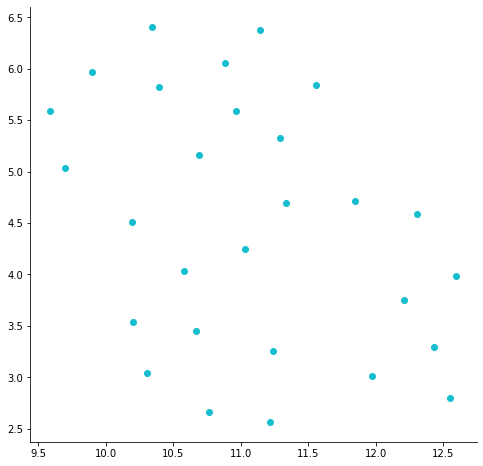

In [40]:
color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
for cluster_number in np.unique(clus.labels_):
    cluster_mask = clus.labels_ == cluster_number
    plt.plot(embedding[cluster_mask, 0], embedding[cluster_mask,1], '.', color=color_cycle[cluster_number], ms=12)
sns.despine()
plt.gcf().set_size_inches(8, 8)

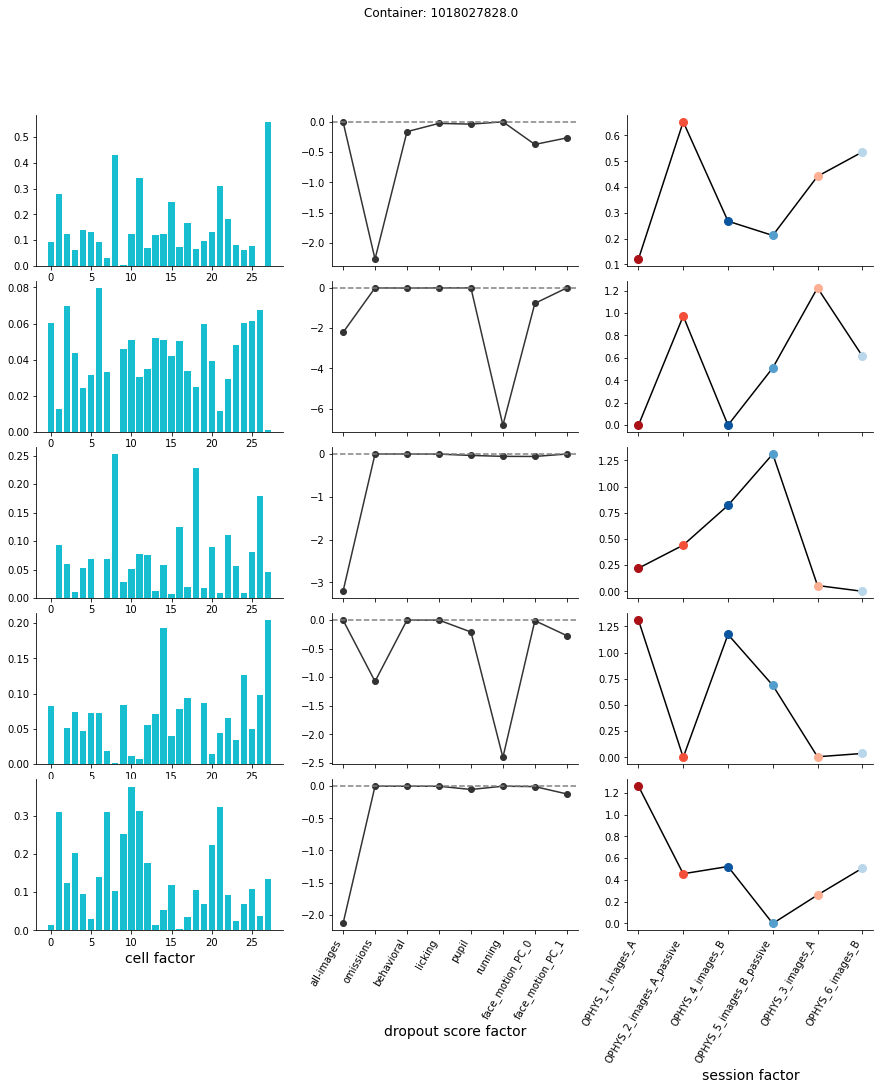

In [41]:
tca.container_tca_plot(cluster_labels=clus.labels_)

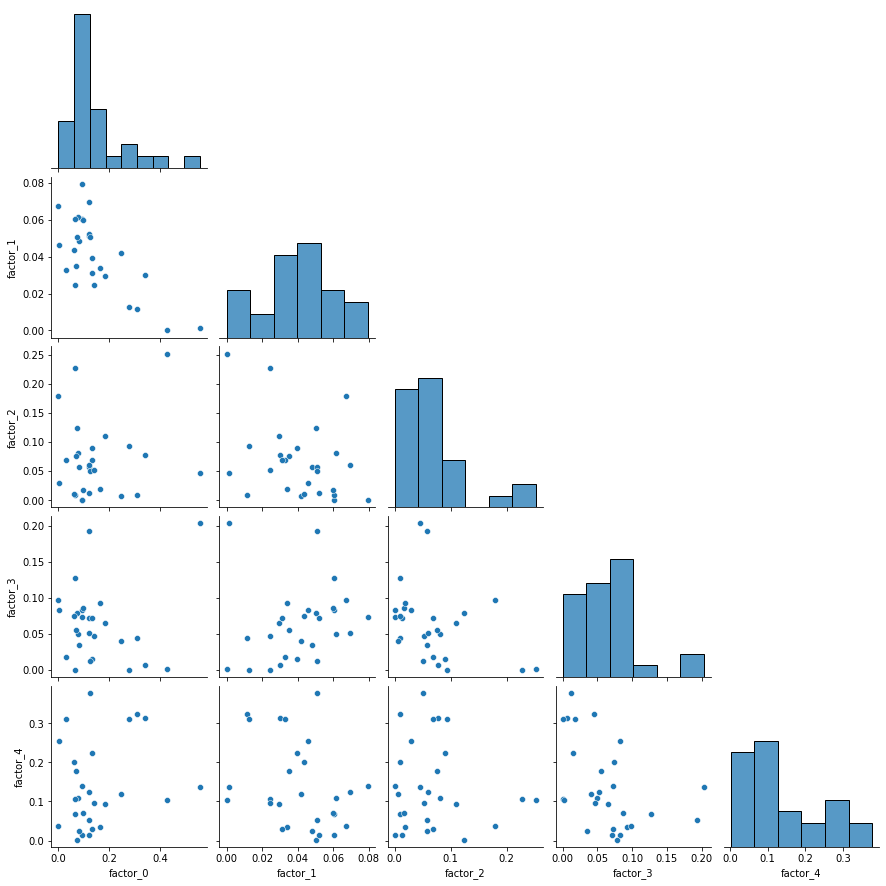

In [42]:
tca.all_cell_factor_correlation_plot()

---

In [43]:
container_id = slc_containers_sorted_by_average_number_of_cells.index[2]
container_id

814796612.0

In [44]:
tca = ContainerTCA(container_id=container_id, rspm=rspm, features=clustering_features)

NCP_HALS: iteration 1, objective 0.4632846055839417, improvement inf.
NCP_HALS: iteration 2, objective 0.41719397629241434, improvement 0.04609062929152735.
NCP_HALS: iteration 3, objective 0.4055688770124958, improvement 0.01162509927991856.
NCP_HALS: iteration 4, objective 0.400821616866568, improvement 0.004747260145927801.
NCP_HALS: iteration 5, objective 0.3981436640591941, improvement 0.0026779528073738734.
NCP_HALS: iteration 6, objective 0.3964450323516357, improvement 0.0016986317075584068.
NCP_HALS: iteration 7, objective 0.39338900134265514, improvement 0.003056031008980553.
NCP_HALS: iteration 8, objective 0.38209274161033985, improvement 0.011296259732315295.
NCP_HALS: iteration 9, objective 0.3507311877232144, improvement 0.03136155388712547.
NCP_HALS: iteration 10, objective 0.3275838904961437, improvement 0.02314729722707065.
NCP_HALS: iteration 11, objective 0.3194873608285149, improvement 0.008096529667628805.
NCP_HALS: iteration 12, objective 0.31584966342753534, imp

In [45]:
reducer = umap.UMAP()
cell_fac_df = tca.get_factor_df(factor='cell')
embedding = reducer.fit_transform(cell_fac_df.values)
embedding.shape

(69, 2)

In [46]:
clus = DBSCAN(eps=0.50, min_samples=5).fit(embedding)

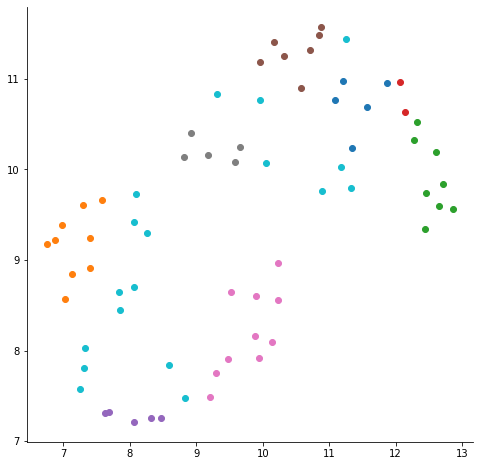

In [47]:
color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
for cluster_number in np.unique(clus.labels_):
    cluster_mask = clus.labels_ == cluster_number
    plt.plot(embedding[cluster_mask, 0], embedding[cluster_mask,1], '.', color=color_cycle[cluster_number], ms=12)
sns.despine()
plt.gcf().set_size_inches(8, 8)

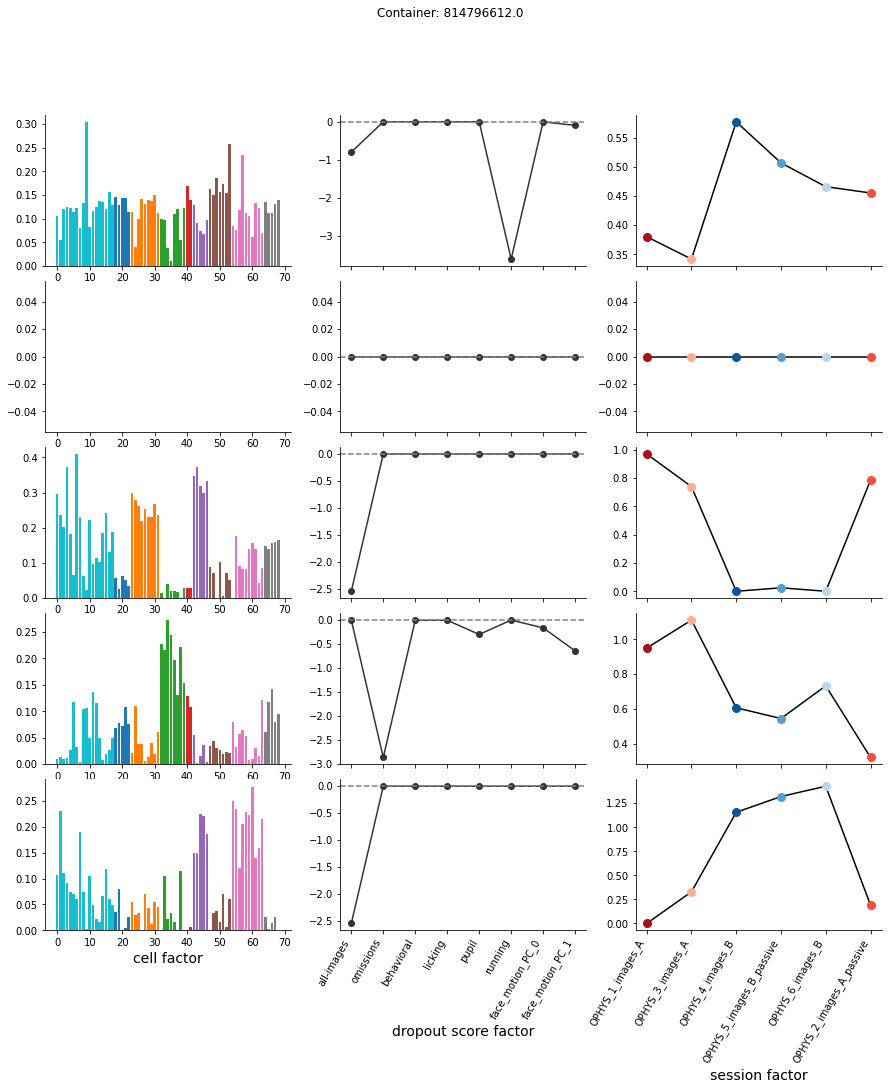

In [48]:
tca.container_tca_plot(cluster_labels=clus.labels_)

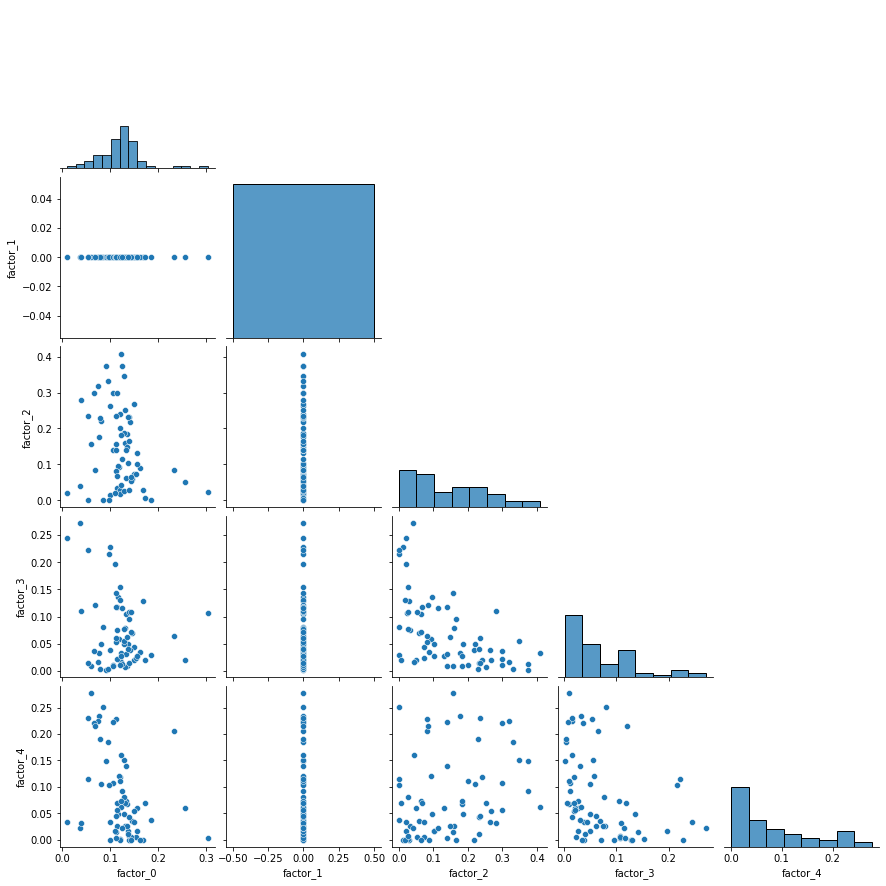

In [49]:
tca.all_cell_factor_correlation_plot()

---

In [50]:
container_id = slc_containers_sorted_by_average_number_of_cells.index[3]
container_id

803589437.0

In [51]:
tca = ContainerTCA(container_id=container_id, rspm=rspm, features=clustering_features)

NCP_HALS: iteration 1, objective 0.4659236867610284, improvement inf.
NCP_HALS: iteration 2, objective 0.3932111740855315, improvement 0.07271251267549689.
NCP_HALS: iteration 3, objective 0.36518928949886703, improvement 0.02802188458666449.
NCP_HALS: iteration 4, objective 0.35713030601247, improvement 0.008058983486397053.
NCP_HALS: iteration 5, objective 0.35473206546175906, improvement 0.0023982405507109172.
NCP_HALS: iteration 6, objective 0.35360681914332187, improvement 0.0011252463184371897.
NCP_HALS: iteration 7, objective 0.35241733556203897, improvement 0.0011894835812829019.
NCP_HALS: iteration 8, objective 0.35014226647702534, improvement 0.0022750690850136257.
NCP_HALS: iteration 9, objective 0.34487765346010396, improvement 0.005264613016921382.
NCP_HALS: iteration 10, objective 0.33571298482093376, improvement 0.009164668639170204.
NCP_HALS: iteration 11, objective 0.3284267476271047, improvement 0.007286237193829037.
NCP_HALS: iteration 12, objective 0.323235070203899

In [52]:
reducer = umap.UMAP()
cell_fac_df = tca.get_factor_df(factor='cell')
embedding = reducer.fit_transform(cell_fac_df.values)
embedding.shape

(33, 2)

In [53]:
clus = DBSCAN(eps=0.54, min_samples=5).fit(embedding)

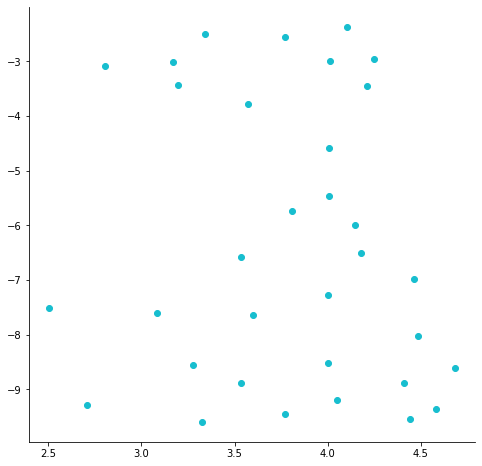

In [54]:
color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
for cluster_number in np.unique(clus.labels_):
    cluster_mask = clus.labels_ == cluster_number
    plt.plot(embedding[cluster_mask, 0], embedding[cluster_mask,1], '.', color=color_cycle[cluster_number], ms=12)
sns.despine()
plt.gcf().set_size_inches(8, 8)

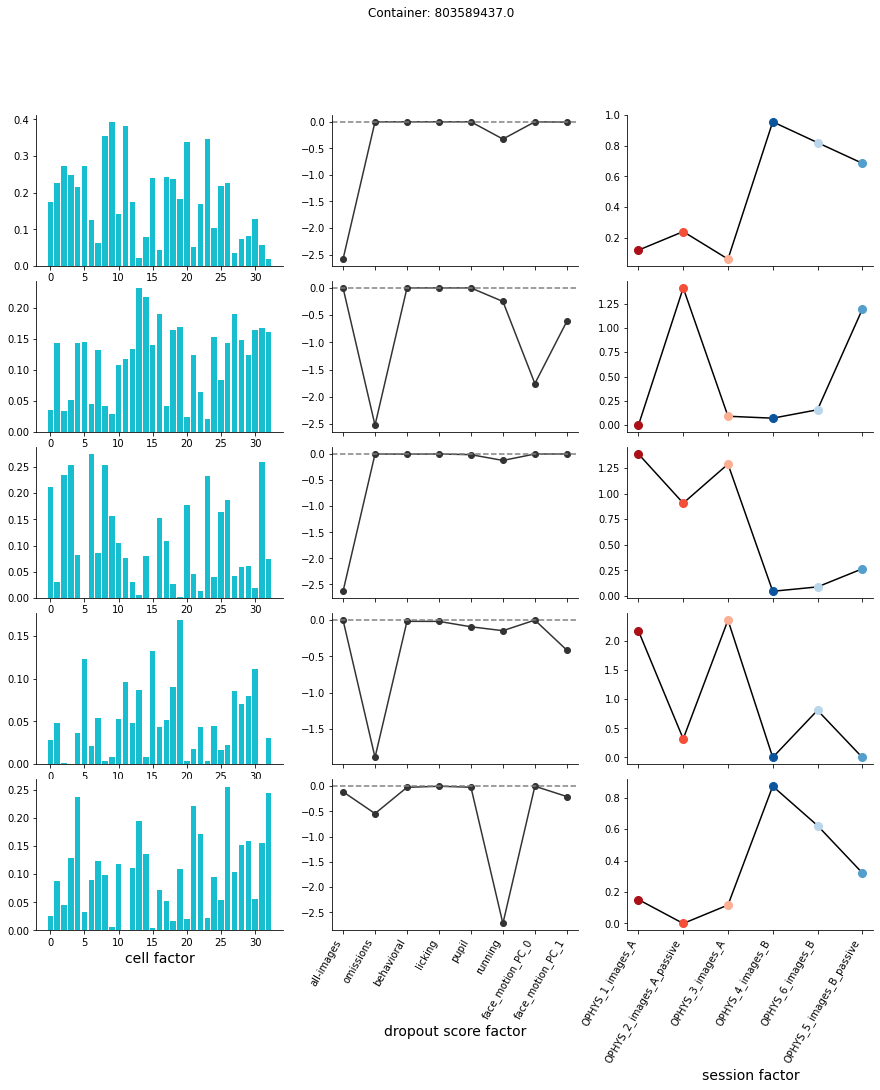

In [55]:
tca.container_tca_plot(cluster_labels=clus.labels_)

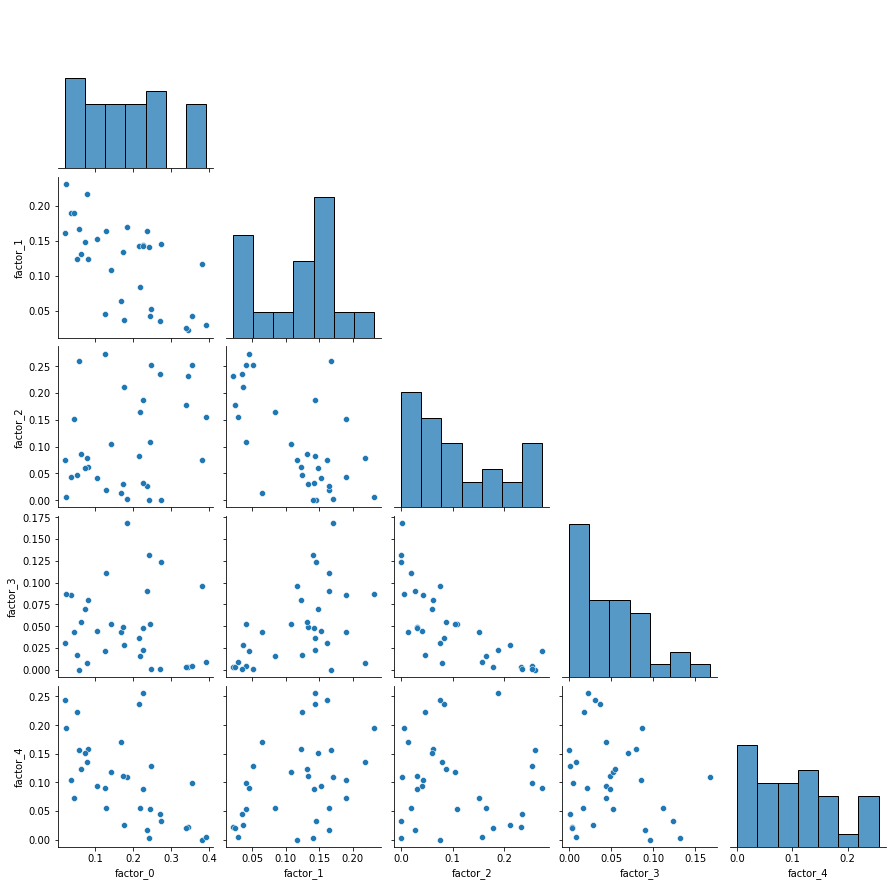

In [56]:
tca.all_cell_factor_correlation_plot()

---

In [57]:
container_id = slc_containers_sorted_by_average_number_of_cells.index[4]
container_id

1018027778.0

In [58]:
tca = ContainerTCA(container_id=container_id, rspm=rspm, features=clustering_features)

NCP_HALS: iteration 1, objective 0.44943878088837486, improvement inf.
NCP_HALS: iteration 2, objective 0.35605451162000606, improvement 0.09338426926836879.
NCP_HALS: iteration 3, objective 0.34496890403557445, improvement 0.011085607584431612.
NCP_HALS: iteration 4, objective 0.3420612549205589, improvement 0.0029076491150155648.
NCP_HALS: iteration 5, objective 0.34006345847928837, improvement 0.0019977964412705163.
NCP_HALS: iteration 6, objective 0.33854207262647334, improvement 0.001521385852815027.
NCP_HALS: iteration 7, objective 0.3371888834549717, improvement 0.001353189171501623.
NCP_HALS: iteration 8, objective 0.3359756774044084, improvement 0.001213206050563298.
NCP_HALS: iteration 9, objective 0.33513775527292844, improvement 0.0008379221314799845.
NCP_HALS: iteration 10, objective 0.3345781766438768, improvement 0.0005595786290516491.
NCP_HALS: iteration 11, objective 0.3341023940105979, improvement 0.00047578263327890946.
NCP_HALS: iteration 12, objective 0.33369263930

In [59]:
reducer = umap.UMAP()
cell_fac_df = tca.get_factor_df(factor='cell')
embedding = reducer.fit_transform(cell_fac_df.values)
embedding.shape

(19, 2)

In [60]:
clus = DBSCAN(eps=0.60, min_samples=5).fit(embedding)

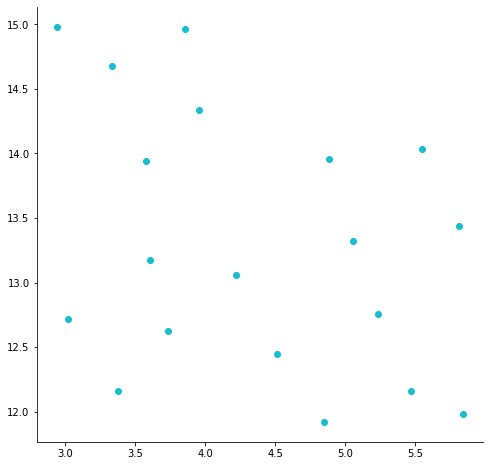

In [61]:
color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
for cluster_number in np.unique(clus.labels_):
    cluster_mask = clus.labels_ == cluster_number
    plt.plot(embedding[cluster_mask, 0], embedding[cluster_mask,1], '.', color=color_cycle[cluster_number], ms=12)
sns.despine()
plt.gcf().set_size_inches(8, 8)

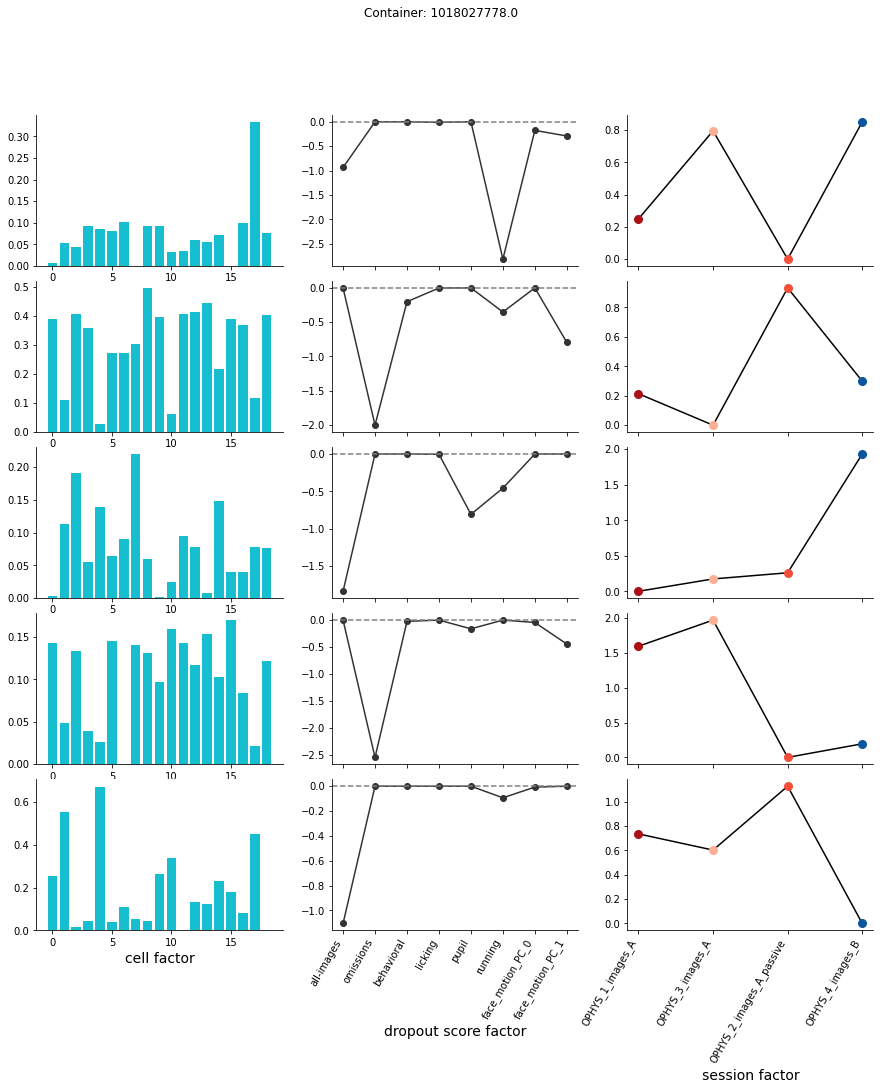

In [62]:
tca.container_tca_plot(cluster_labels=clus.labels_)

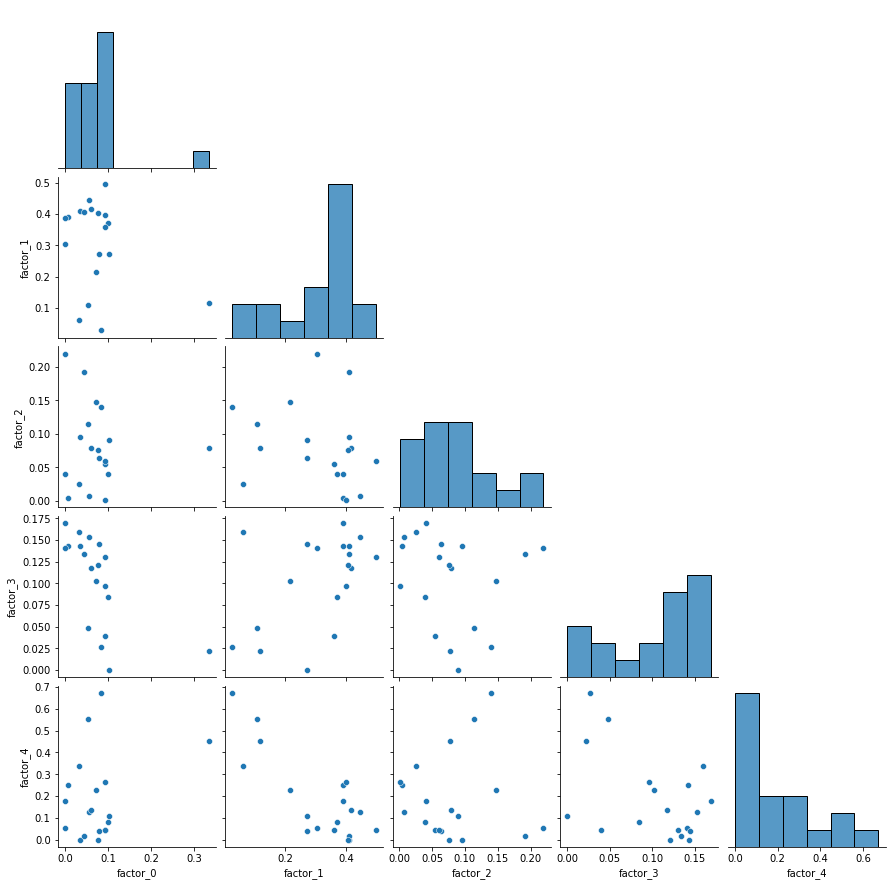

In [63]:
tca.all_cell_factor_correlation_plot()

---

In [64]:
container_id = slc_containers_sorted_by_average_number_of_cells.index[5]
container_id

803517529.0

In [65]:
tca = ContainerTCA(container_id=container_id, rspm=rspm, features=clustering_features)

NCP_HALS: iteration 1, objective 0.42368866179213693, improvement inf.
NCP_HALS: iteration 2, objective 0.3758779828604206, improvement 0.04781067893171631.
NCP_HALS: iteration 3, objective 0.36465658789457317, improvement 0.011221394965847453.
NCP_HALS: iteration 4, objective 0.35388443974655986, improvement 0.010772148148013305.
NCP_HALS: iteration 5, objective 0.34539104374556645, improvement 0.008493396000993414.
NCP_HALS: iteration 6, objective 0.34104953370484825, improvement 0.0043415100407181995.
NCP_HALS: iteration 7, objective 0.3392088992986194, improvement 0.001840634406228836.
NCP_HALS: iteration 8, objective 0.3381451796364711, improvement 0.0010637196621482992.
NCP_HALS: iteration 9, objective 0.3373120587210118, improvement 0.00083312091545934.
NCP_HALS: iteration 10, objective 0.3365946462930805, improvement 0.0007174124279312744.
NCP_HALS: iteration 11, objective 0.336099468264037, improvement 0.0004951780290434749.
NCP_HALS: iteration 12, objective 0.3358538851175191

In [66]:
reducer = umap.UMAP()
cell_fac_df = tca.get_factor_df(factor='cell')
embedding = reducer.fit_transform(cell_fac_df.values)
embedding.shape

(54, 2)

In [67]:
clus = DBSCAN(eps=0.54, min_samples=5).fit(embedding)

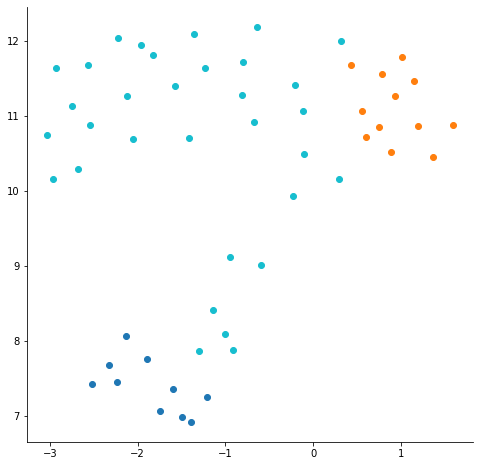

In [68]:
color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
for cluster_number in np.unique(clus.labels_):
    cluster_mask = clus.labels_ == cluster_number
    plt.plot(embedding[cluster_mask, 0], embedding[cluster_mask,1], '.', color=color_cycle[cluster_number], ms=12)
sns.despine()
plt.gcf().set_size_inches(8, 8)

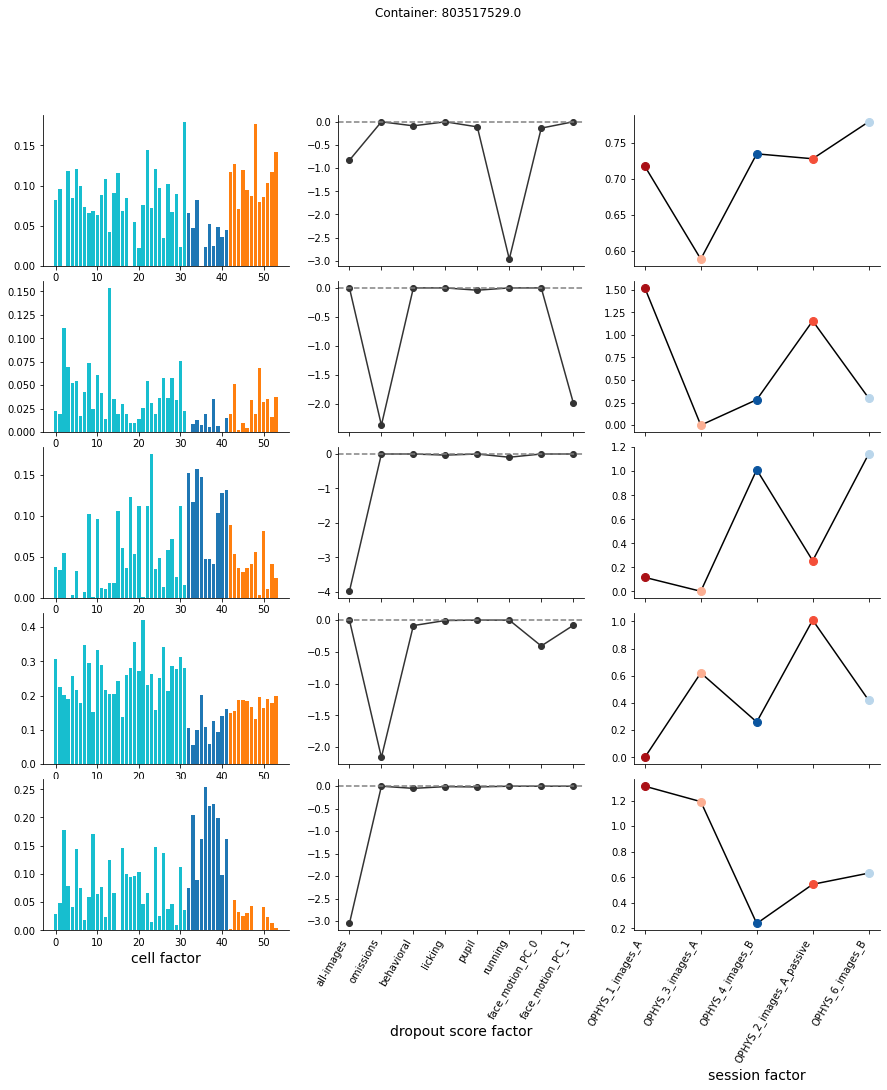

In [69]:
tca.container_tca_plot(cluster_labels=clus.labels_)

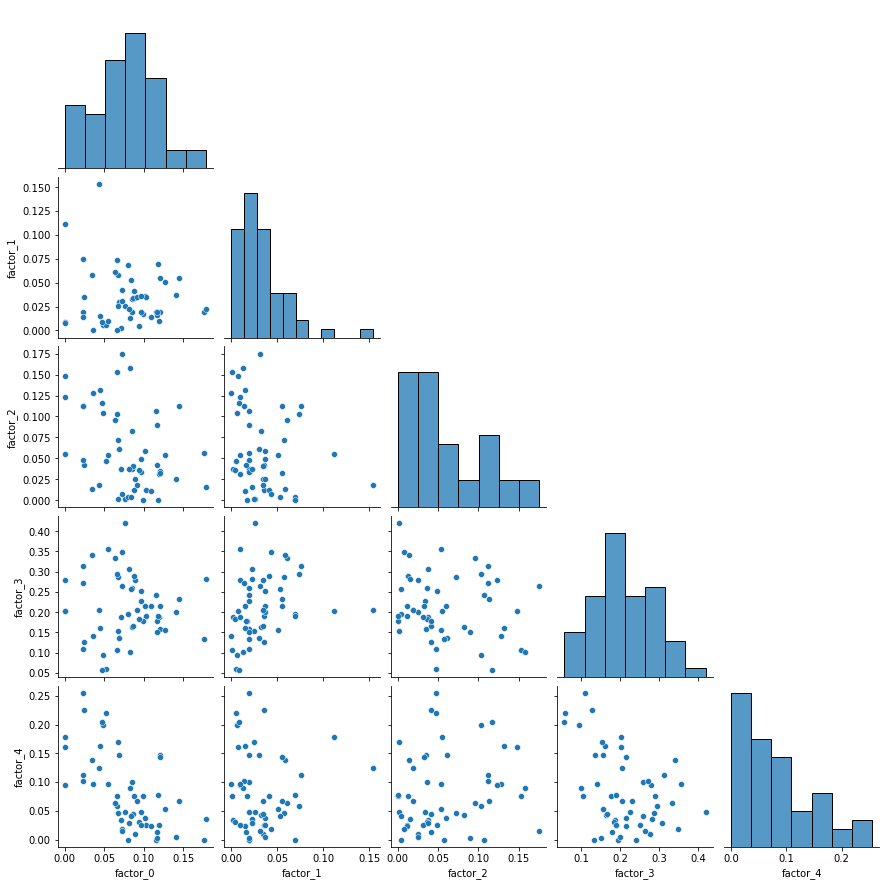

In [70]:
tca.all_cell_factor_correlation_plot()

---

In [71]:
container_id = slc_containers_sorted_by_average_number_of_cells.index[6]
container_id

991913064.0

In [72]:
tca = ContainerTCA(container_id=container_id, rspm=rspm, features=clustering_features)

NCP_HALS: iteration 1, objective 0.42975752704281434, improvement inf.
NCP_HALS: iteration 2, objective 0.36100565515099337, improvement 0.06875187189182097.
NCP_HALS: iteration 3, objective 0.3433678643784991, improvement 0.017637790772494277.
NCP_HALS: iteration 4, objective 0.329915756436752, improvement 0.013452107941747116.
NCP_HALS: iteration 5, objective 0.31985883370670876, improvement 0.010056922730043216.
NCP_HALS: iteration 6, objective 0.3146293261505002, improvement 0.005229507556208546.
NCP_HALS: iteration 7, objective 0.3118609193832009, improvement 0.002768406767299336.
NCP_HALS: iteration 8, objective 0.31010862137155004, improvement 0.0017522980116508324.
NCP_HALS: iteration 9, objective 0.30888706062571986, improvement 0.0012215607458301858.
NCP_HALS: iteration 10, objective 0.3080331710027, improvement 0.0008538896230198545.
NCP_HALS: iteration 11, objective 0.30750086531959736, improvement 0.0005323056831026407.
NCP_HALS: iteration 12, objective 0.3071760379954437,

In [73]:
reducer = umap.UMAP()
cell_fac_df = tca.get_factor_df(factor='cell')
embedding = reducer.fit_transform(cell_fac_df.values)
embedding.shape

/home/nick.ponvert/.conda/envs/nick/lib/python3.7/site-packages/umap/umap_.py:1679: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  "n_neighbors is larger than the dataset size; truncating to "


(7, 2)

In [74]:
clus = DBSCAN(eps=0.8, min_samples=5).fit(embedding)

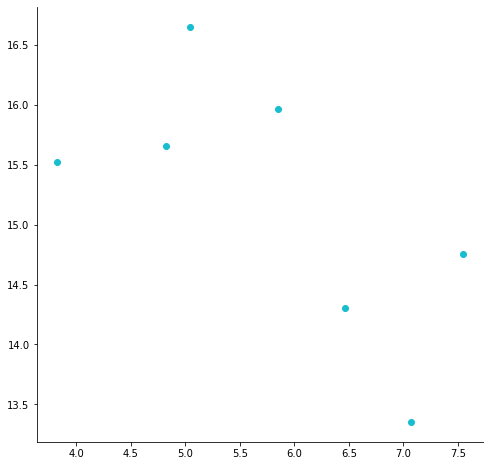

In [75]:
color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
for cluster_number in np.unique(clus.labels_):
    cluster_mask = clus.labels_ == cluster_number
    plt.plot(embedding[cluster_mask, 0], embedding[cluster_mask,1], '.', color=color_cycle[cluster_number], ms=12)
sns.despine()
plt.gcf().set_size_inches(8, 8)

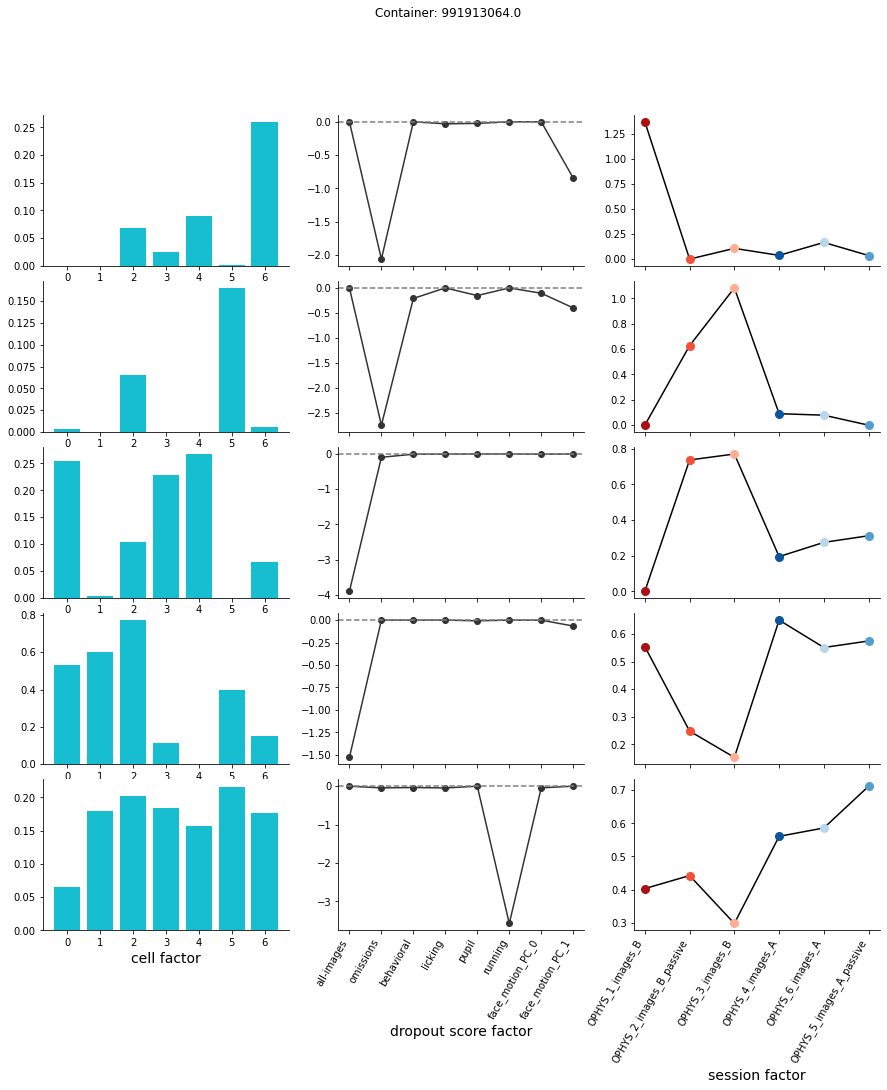

In [76]:
tca.container_tca_plot(cluster_labels=clus.labels_)

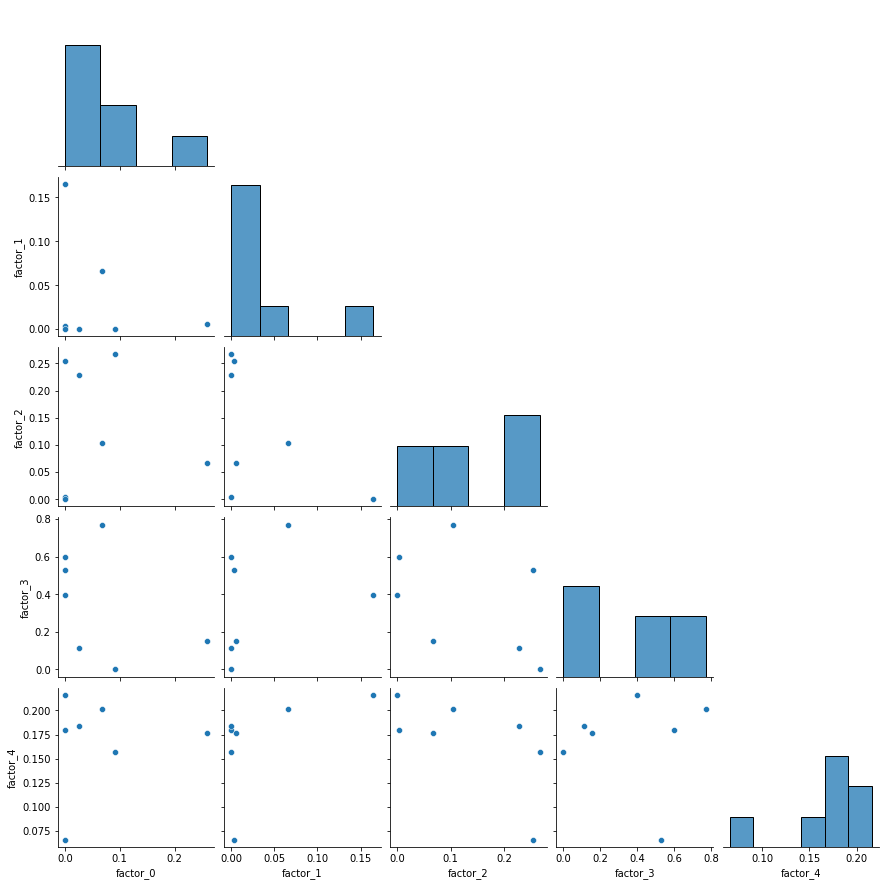

In [77]:
tca.all_cell_factor_correlation_plot()

---

In [78]:
container_id = slc_containers_sorted_by_average_number_of_cells.index[7]
container_id

906963896.0

In [79]:
tca = ContainerTCA(container_id=container_id, rspm=rspm, features=clustering_features)

NCP_HALS: iteration 1, objective 0.5239822755959888, improvement inf.
NCP_HALS: iteration 2, objective 0.46764175487404686, improvement 0.0563405207219419.
NCP_HALS: iteration 3, objective 0.441510413222472, improvement 0.02613134165157488.
NCP_HALS: iteration 4, objective 0.4231594037470678, improvement 0.01835100947540419.
NCP_HALS: iteration 5, objective 0.405309046975361, improvement 0.017850356771706766.
NCP_HALS: iteration 6, objective 0.3894014395561659, improvement 0.015907607419195113.
NCP_HALS: iteration 7, objective 0.38154278287418814, improvement 0.007858656681977771.
NCP_HALS: iteration 8, objective 0.3782957870347098, improvement 0.0032469958394783505.
NCP_HALS: iteration 9, objective 0.37677453227892493, improvement 0.001521254755784851.
NCP_HALS: iteration 10, objective 0.37583452846388127, improvement 0.0009400038150436663.
NCP_HALS: iteration 11, objective 0.37515222416862354, improvement 0.0006823042952577296.
NCP_HALS: iteration 12, objective 0.3746057314717299, im

In [80]:
reducer = umap.UMAP()
cell_fac_df = tca.get_factor_df(factor='cell')
embedding = reducer.fit_transform(cell_fac_df.values)
embedding.shape

(56, 2)

In [81]:
clus = DBSCAN(eps=0.58, min_samples=5).fit(embedding)

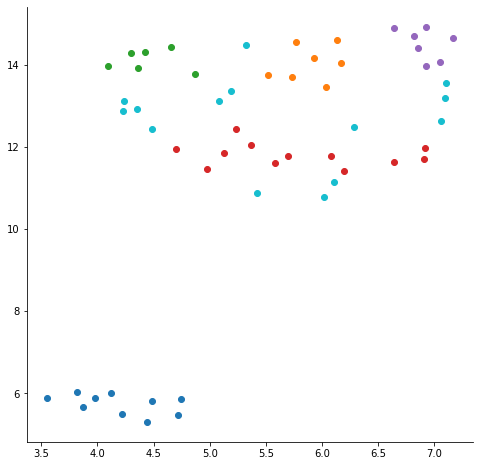

In [82]:
color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
for cluster_number in np.unique(clus.labels_):
    cluster_mask = clus.labels_ == cluster_number
    plt.plot(embedding[cluster_mask, 0], embedding[cluster_mask,1], '.', color=color_cycle[cluster_number], ms=12)
sns.despine()
plt.gcf().set_size_inches(8, 8)

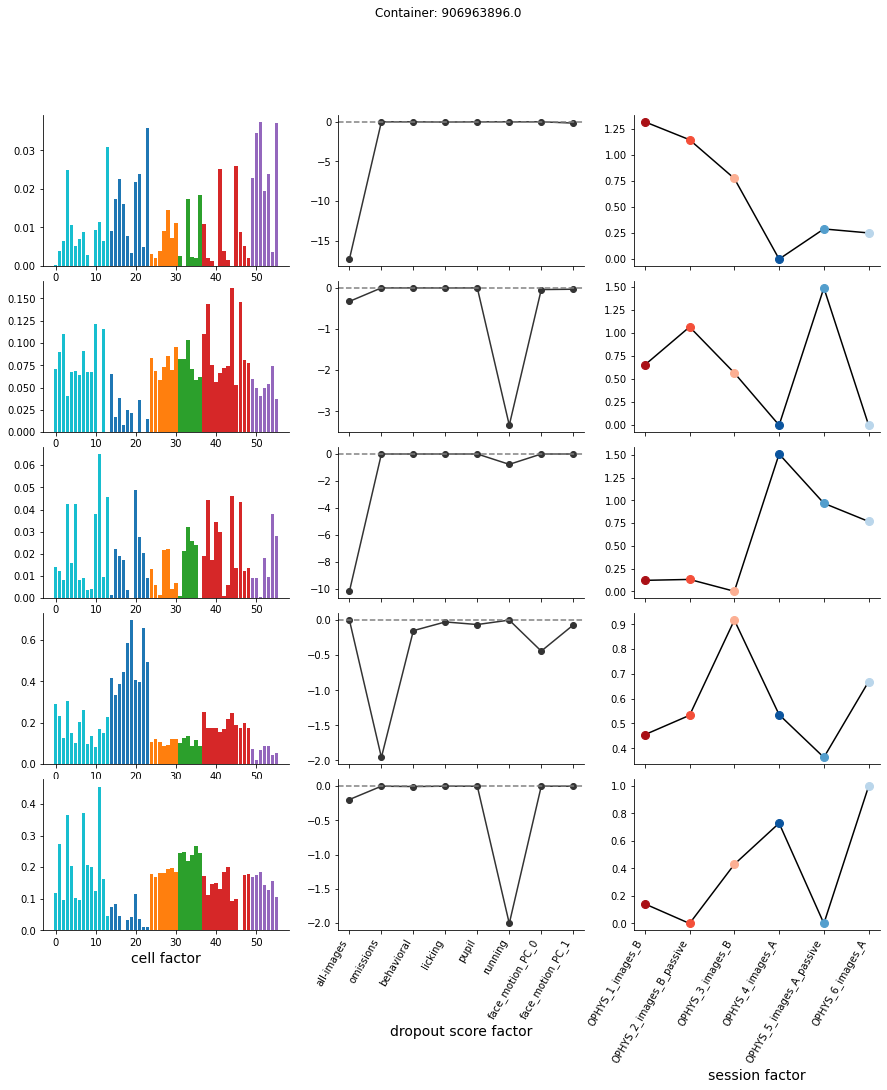

In [83]:
tca.container_tca_plot(cluster_labels=clus.labels_)

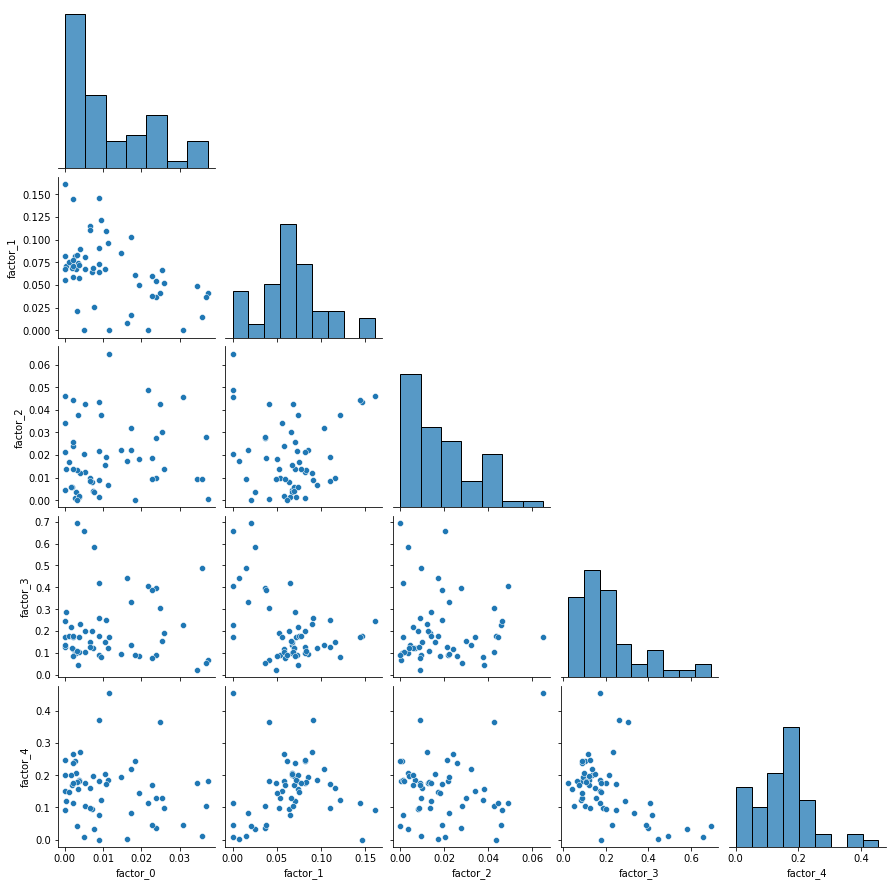

In [84]:
tca.all_cell_factor_correlation_plot()

---

In [85]:
container_id = slc_containers_sorted_by_average_number_of_cells.index[8]
container_id

829561794.0

In [86]:
tca = ContainerTCA(container_id=container_id, rspm=rspm, features=clustering_features)

NCP_HALS: iteration 1, objective 0.4682299824706939, improvement inf.
NCP_HALS: iteration 2, objective 0.3822139581661409, improvement 0.08601602430455302.
NCP_HALS: iteration 3, objective 0.35946305320548066, improvement 0.022750904960660234.
NCP_HALS: iteration 4, objective 0.3528537557417558, improvement 0.00660929746372485.
NCP_HALS: iteration 5, objective 0.34904957243629686, improvement 0.0038041833054589524.
NCP_HALS: iteration 6, objective 0.33913225546130826, improvement 0.0099173169749886.
NCP_HALS: iteration 7, objective 0.3218709123082717, improvement 0.017261343153036568.
NCP_HALS: iteration 8, objective 0.3157543294614723, improvement 0.00611658284679939.
NCP_HALS: iteration 9, objective 0.31454324715072385, improvement 0.001211082310748457.
NCP_HALS: iteration 10, objective 0.3140761083487143, improvement 0.00046713880200954794.
NCP_HALS: iteration 11, objective 0.3137875085119436, improvement 0.0002885998367707088.
NCP_HALS: iteration 12, objective 0.3135773927603861, i

In [87]:
reducer = umap.UMAP()
cell_fac_df = tca.get_factor_df(factor='cell')
embedding = reducer.fit_transform(cell_fac_df.values)
embedding.shape

(62, 2)

In [88]:
clus = DBSCAN(eps=0.8, min_samples=5).fit(embedding)

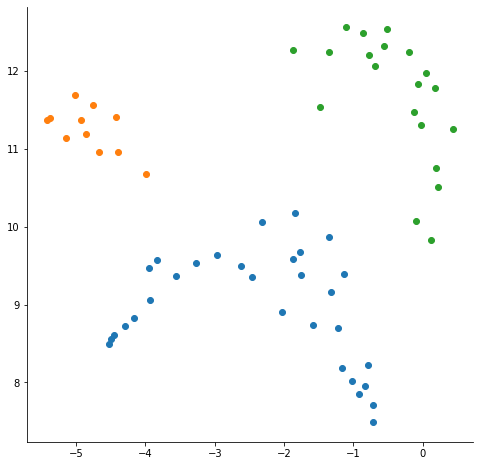

In [89]:
color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
for cluster_number in np.unique(clus.labels_):
    cluster_mask = clus.labels_ == cluster_number
    plt.plot(embedding[cluster_mask, 0], embedding[cluster_mask,1], '.', color=color_cycle[cluster_number], ms=12)
sns.despine()
plt.gcf().set_size_inches(8, 8)

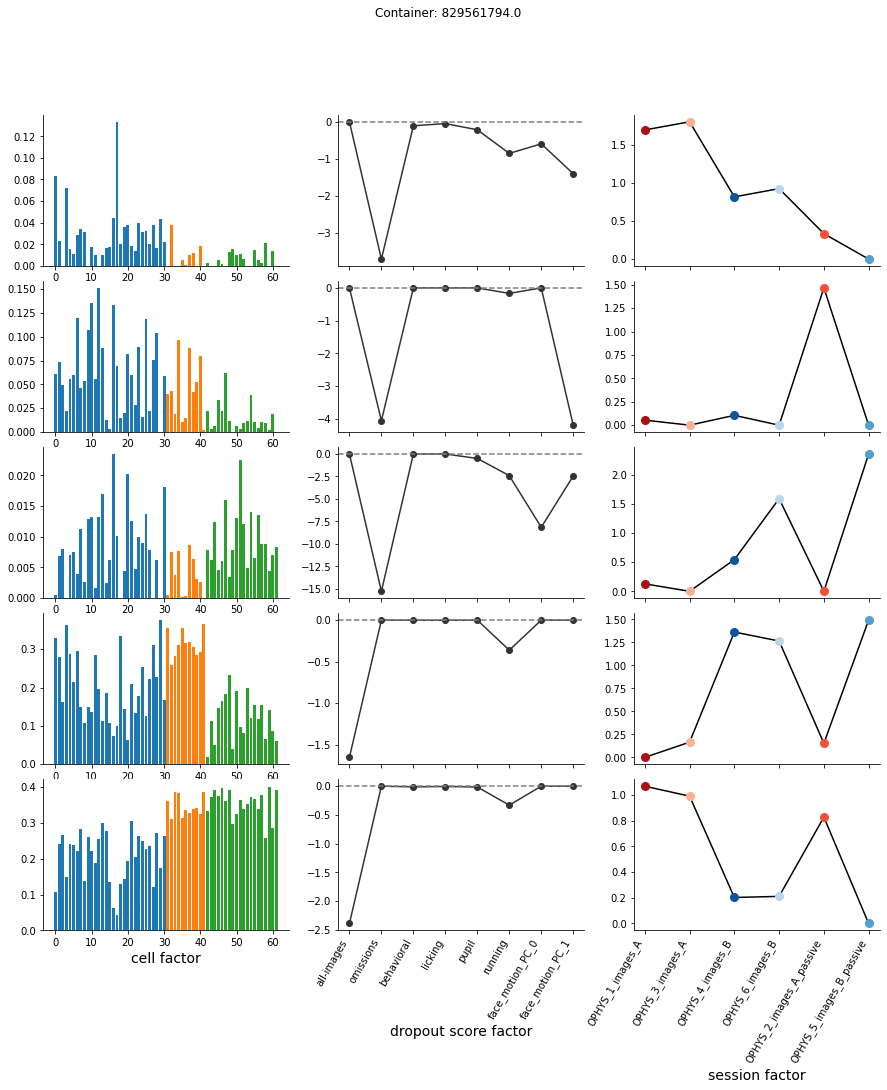

In [90]:
tca.container_tca_plot(cluster_labels=clus.labels_)

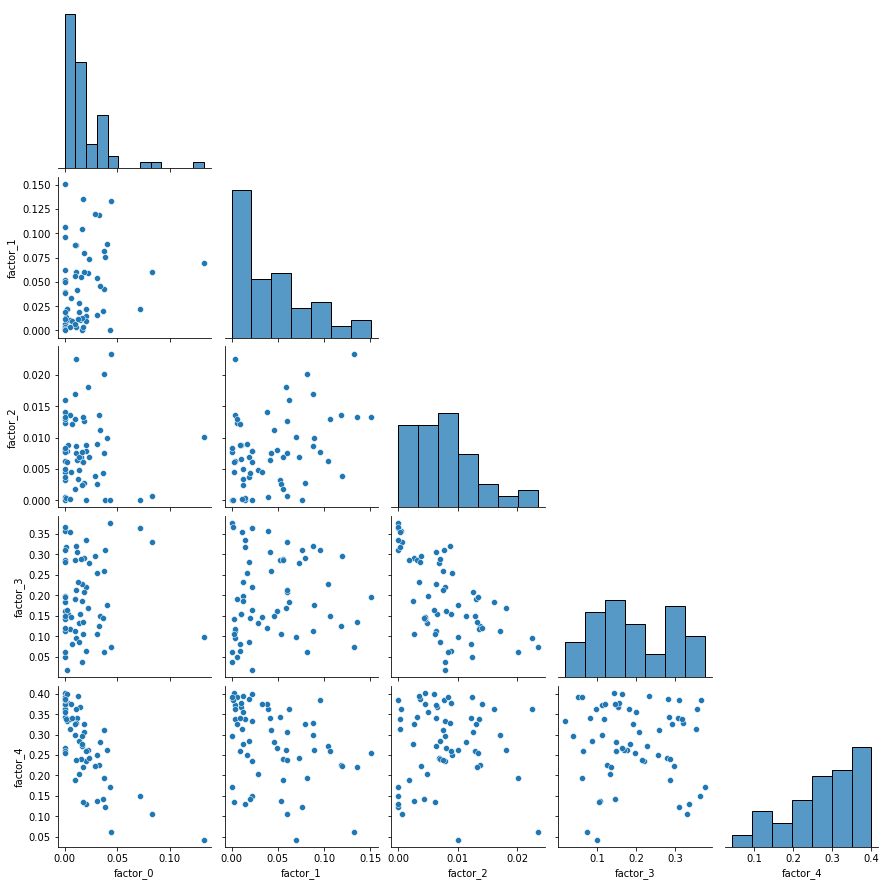

In [91]:
tca.all_cell_factor_correlation_plot()

---

In [92]:
container_id = slc_containers_sorted_by_average_number_of_cells.index[9]
container_id

1040782478.0

In [93]:
tca = ContainerTCA(container_id=container_id, rspm=rspm, features=clustering_features)

NCP_HALS: iteration 1, objective 0.18677292142778118, improvement inf.
NCP_HALS: iteration 2, objective 0.14205453272631435, improvement 0.04471838870146683.
NCP_HALS: iteration 3, objective 0.13686324772192407, improvement 0.005191285004390284.
NCP_HALS: iteration 4, objective 0.13495126040144922, improvement 0.001911987320474845.
NCP_HALS: iteration 5, objective 0.13260370396399052, improvement 0.002347556437458709.
NCP_HALS: iteration 6, objective 0.12995911496416768, improvement 0.002644588999822839.
NCP_HALS: iteration 7, objective 0.12643848567848148, improvement 0.0035206292856861943.
NCP_HALS: iteration 8, objective 0.12155015328800244, improvement 0.004888332390479047.
NCP_HALS: iteration 9, objective 0.11566949427972407, improvement 0.0058806590082783605.
NCP_HALS: iteration 10, objective 0.11013614622104861, improvement 0.005533348058675461.
NCP_HALS: iteration 11, objective 0.10480294555123193, improvement 0.0053332006698166845.
NCP_HALS: iteration 12, objective 0.100164680

In [94]:
reducer = umap.UMAP()
cell_fac_df = tca.get_factor_df(factor='cell')
embedding = reducer.fit_transform(cell_fac_df.values)
embedding.shape

(1, 2)

In [95]:
clus = DBSCAN(eps=0.58, min_samples=5).fit(embedding)

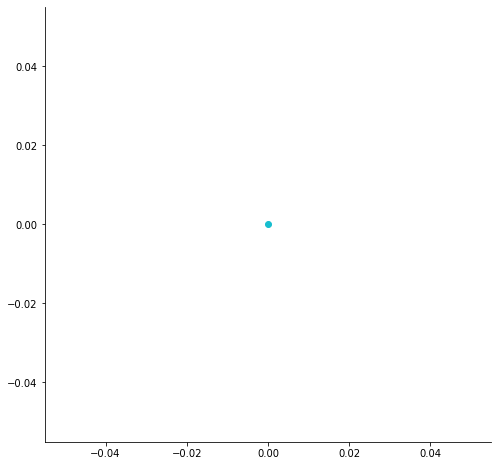

In [96]:
color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
for cluster_number in np.unique(clus.labels_):
    cluster_mask = clus.labels_ == cluster_number
    plt.plot(embedding[cluster_mask, 0], embedding[cluster_mask,1], '.', color=color_cycle[cluster_number], ms=12)
sns.despine()
plt.gcf().set_size_inches(8, 8)

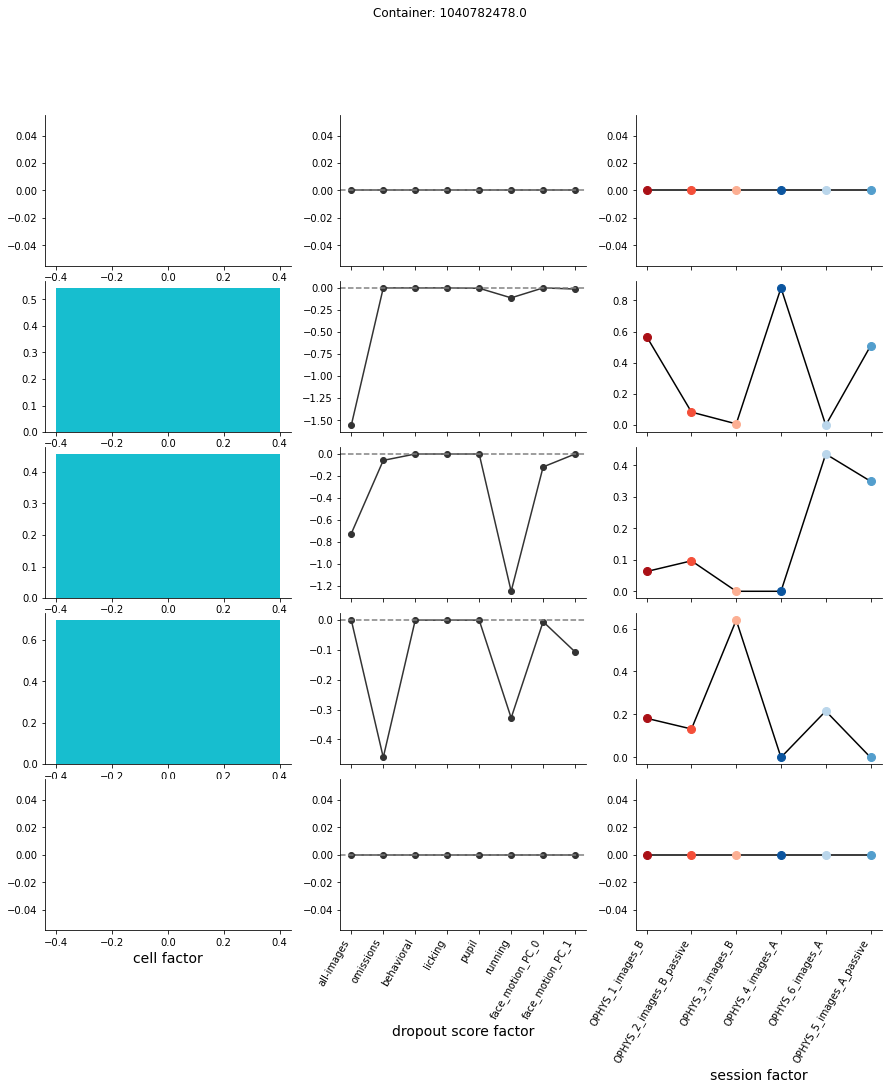

In [97]:
tca.container_tca_plot(cluster_labels=clus.labels_)

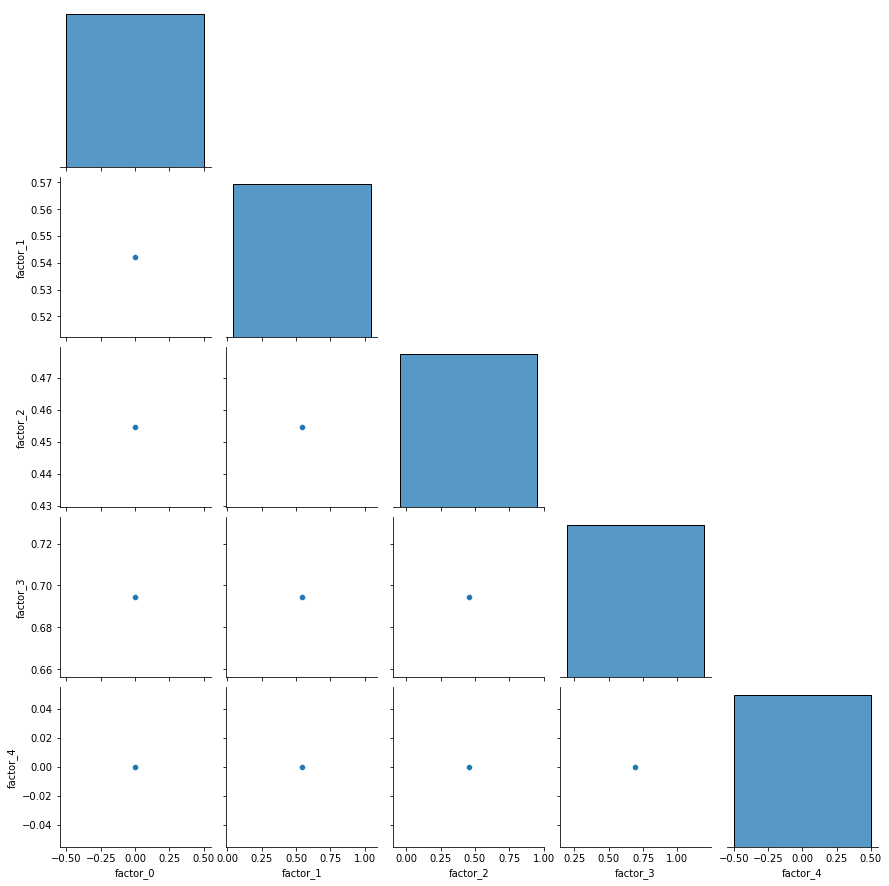

In [98]:
tca.all_cell_factor_correlation_plot()

---

In [99]:
container_id = slc_containers_sorted_by_average_number_of_cells.index[10]
container_id

845588020.0

In [100]:
tca = ContainerTCA(container_id=container_id, rspm=rspm, features=clustering_features)

NCP_HALS: iteration 1, objective 0.47843509574130105, improvement inf.
NCP_HALS: iteration 2, objective 0.3936414232661625, improvement 0.08479367247513853.
NCP_HALS: iteration 3, objective 0.3668764833955308, improvement 0.02676493987063172.
NCP_HALS: iteration 4, objective 0.3554440392391796, improvement 0.011432444156351196.
NCP_HALS: iteration 5, objective 0.35121425786681204, improvement 0.004229781372367569.
NCP_HALS: iteration 6, objective 0.34959606776672364, improvement 0.0016181901000884014.
NCP_HALS: iteration 7, objective 0.3485523175636596, improvement 0.00104375020306402.
NCP_HALS: iteration 8, objective 0.3477485583672827, improvement 0.0008037591963769297.
NCP_HALS: iteration 9, objective 0.3466855999819361, improvement 0.0010629583853465907.
NCP_HALS: iteration 10, objective 0.3448396869770342, improvement 0.001845913004901889.
NCP_HALS: iteration 11, objective 0.34201933769847265, improvement 0.0028203492785615625.
NCP_HALS: iteration 12, objective 0.3387928062531256,

In [101]:
reducer = umap.UMAP()
cell_fac_df = tca.get_factor_df(factor='cell')
embedding = reducer.fit_transform(cell_fac_df.values)
embedding.shape

(16, 2)

In [102]:
clus = DBSCAN(eps=0.60, min_samples=5).fit(embedding)

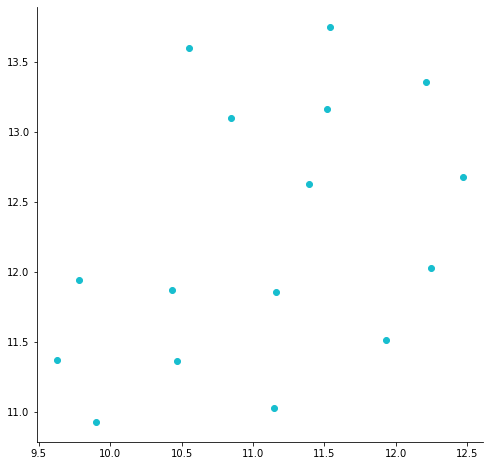

In [103]:
color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
for cluster_number in np.unique(clus.labels_):
    cluster_mask = clus.labels_ == cluster_number
    plt.plot(embedding[cluster_mask, 0], embedding[cluster_mask,1], '.', color=color_cycle[cluster_number], ms=12)
sns.despine()
plt.gcf().set_size_inches(8, 8)

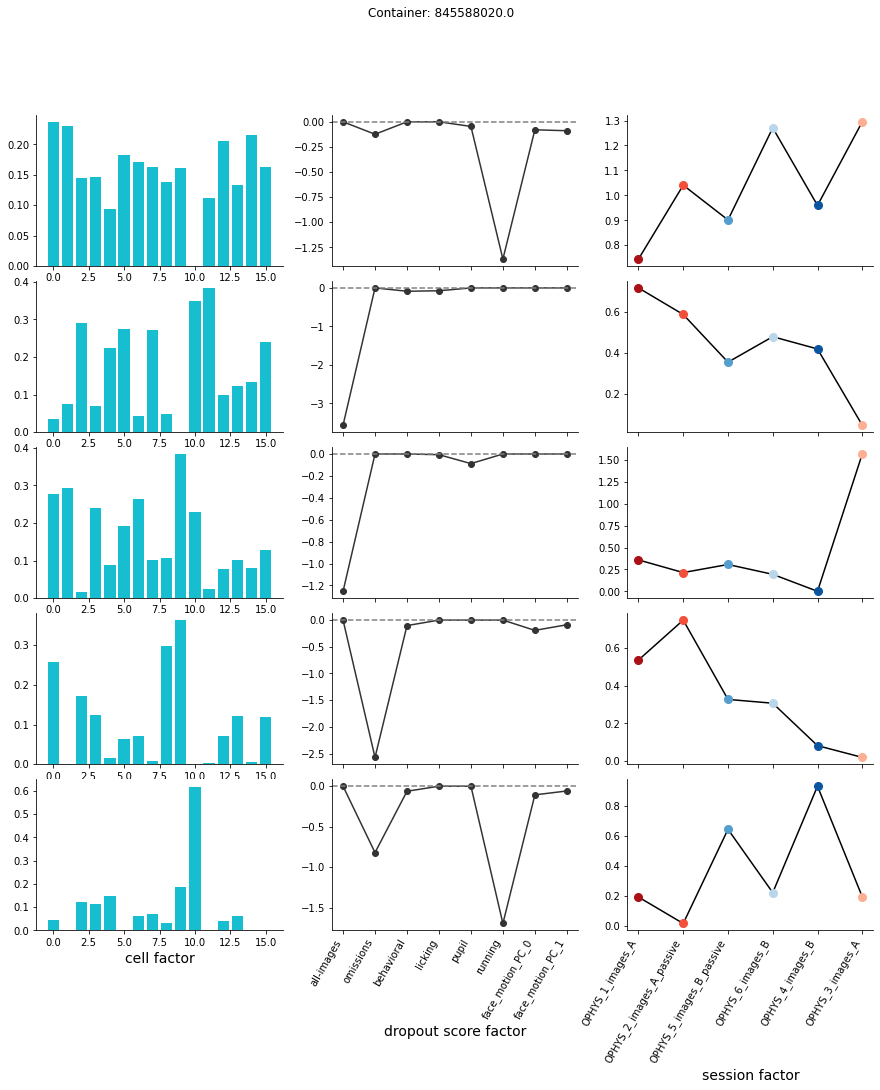

In [104]:
tca.container_tca_plot(cluster_labels=clus.labels_)

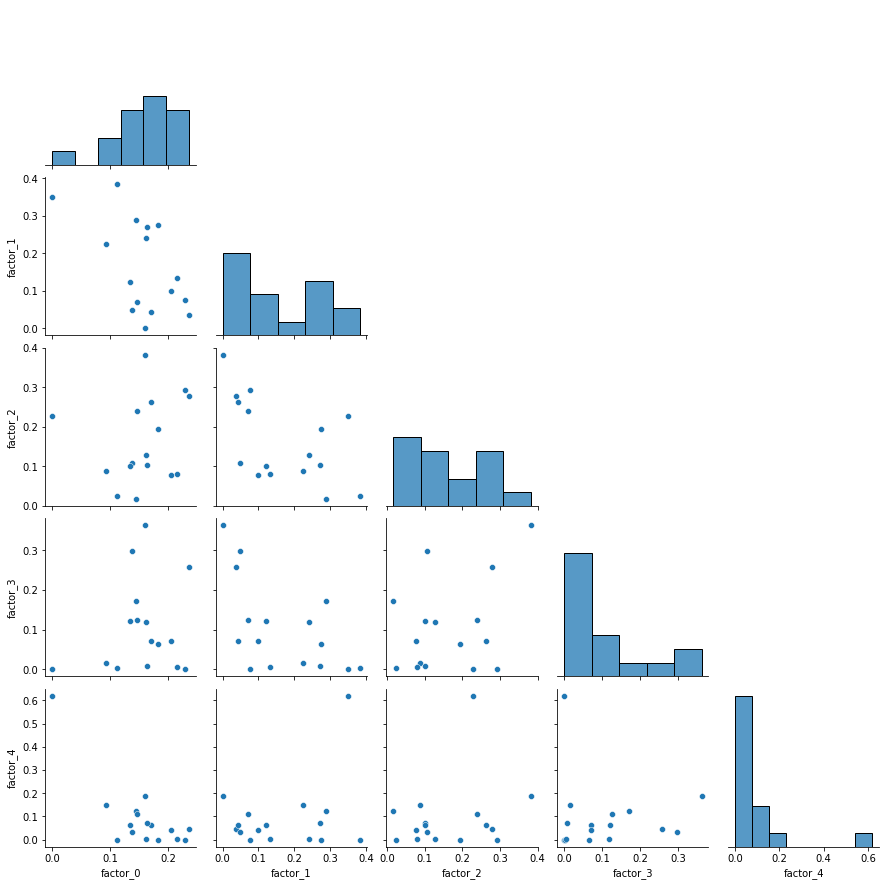

In [105]:
tca.all_cell_factor_correlation_plot()

---

In [106]:
container_id = slc_containers_sorted_by_average_number_of_cells.index[11]
container_id

1018027750.0

In [107]:
tca = ContainerTCA(container_id=container_id, rspm=rspm, features=clustering_features)

NCP_HALS: iteration 1, objective 0.45719768553657114, improvement inf.
NCP_HALS: iteration 2, objective 0.37559185615342416, improvement 0.08160582938314698.
NCP_HALS: iteration 3, objective 0.3586867001787954, improvement 0.01690515597462877.
NCP_HALS: iteration 4, objective 0.3480845513754558, improvement 0.010602148803339595.
NCP_HALS: iteration 5, objective 0.3393580886107578, improvement 0.008726462764698018.
NCP_HALS: iteration 6, objective 0.33485839640907694, improvement 0.004499692201680838.
NCP_HALS: iteration 7, objective 0.33295251181635754, improvement 0.001905884592719398.
NCP_HALS: iteration 8, objective 0.33229272830110657, improvement 0.0006597835152509779.
NCP_HALS: iteration 9, objective 0.33193005430169337, improvement 0.0003626739994131989.
NCP_HALS: iteration 10, objective 0.3317022718124145, improvement 0.00022778248927884936.
NCP_HALS: iteration 11, objective 0.33151895958618816, improvement 0.000183312226226362.
NCP_HALS: iteration 12, objective 0.3313612653299

In [108]:
reducer = umap.UMAP()
cell_fac_df = tca.get_factor_df(factor='cell')
embedding = reducer.fit_transform(cell_fac_df.values)
embedding.shape

/home/nick.ponvert/.conda/envs/nick/lib/python3.7/site-packages/umap/umap_.py:1679: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  "n_neighbors is larger than the dataset size; truncating to "


(6, 2)

In [109]:
clus = DBSCAN(eps=0.65, min_samples=5).fit(embedding)

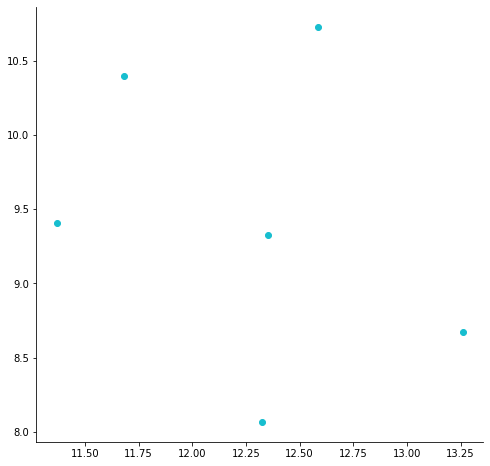

In [110]:
color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
for cluster_number in np.unique(clus.labels_):
    cluster_mask = clus.labels_ == cluster_number
    plt.plot(embedding[cluster_mask, 0], embedding[cluster_mask,1], '.', color=color_cycle[cluster_number], ms=12)
sns.despine()
plt.gcf().set_size_inches(8, 8)

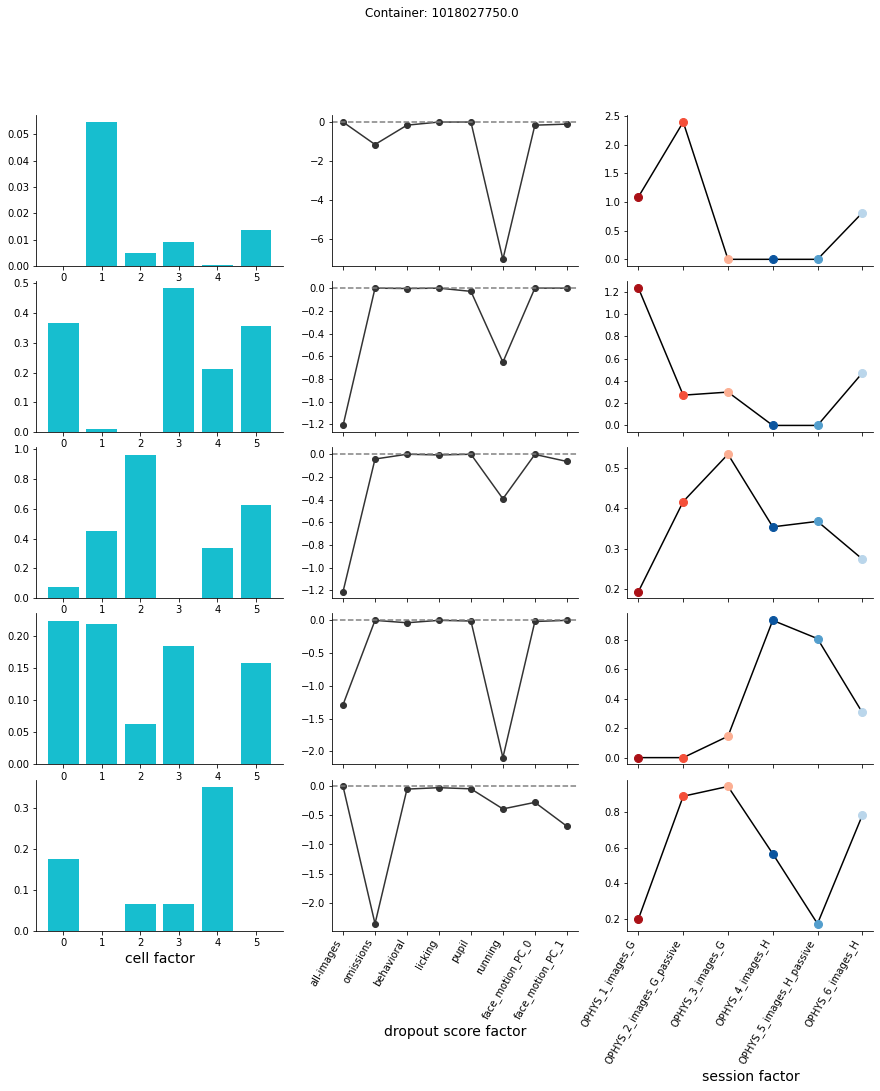

In [111]:
tca.container_tca_plot(cluster_labels=clus.labels_)

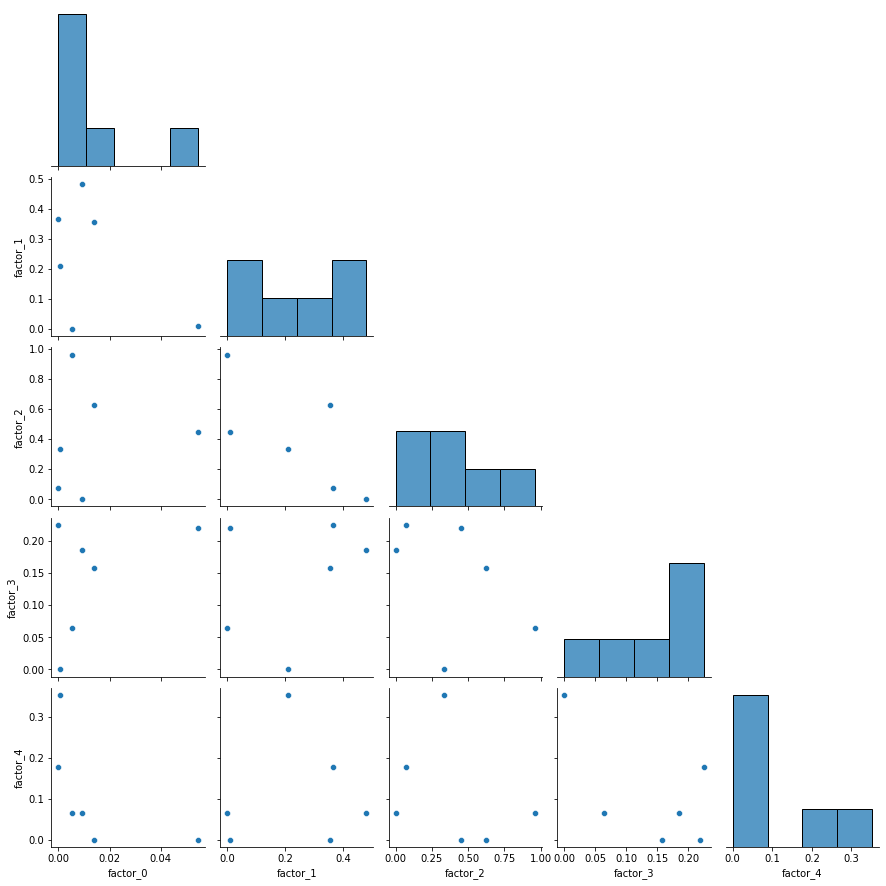

In [112]:
tca.all_cell_factor_correlation_plot()

---

In [113]:
container_id = slc_containers_sorted_by_average_number_of_cells.index[13]
container_id

911248946.0

In [114]:
tca = ContainerTCA(container_id=container_id, rspm=rspm, features=clustering_features)

NCP_HALS: iteration 1, objective 0.48233672193020216, improvement inf.
NCP_HALS: iteration 2, objective 0.3896607574737689, improvement 0.09267596445643328.
NCP_HALS: iteration 3, objective 0.35437900666300537, improvement 0.03528175081076351.
NCP_HALS: iteration 4, objective 0.3242687644361792, improvement 0.030110242226826178.
NCP_HALS: iteration 5, objective 0.3063392806308568, improvement 0.017929483805322388.
NCP_HALS: iteration 6, objective 0.2989189241577377, improvement 0.007420356473119116.
NCP_HALS: iteration 7, objective 0.29547562646860265, improvement 0.0034432976891350386.
NCP_HALS: iteration 8, objective 0.29358666709932263, improvement 0.0018889593692800188.
NCP_HALS: iteration 9, objective 0.2928647619377736, improvement 0.0007219051615490191.
NCP_HALS: iteration 10, objective 0.29254880208978795, improvement 0.00031595984798565846.
NCP_HALS: iteration 11, objective 0.29235277460125336, improvement 0.00019602748853458918.
NCP_HALS: iteration 12, objective 0.29221658663

In [115]:
reducer = umap.UMAP()
cell_fac_df = tca.get_factor_df(factor='cell')
embedding = reducer.fit_transform(cell_fac_df.values)
embedding.shape

(27, 2)

In [116]:
clus = DBSCAN(eps=0.58, min_samples=5).fit(embedding)

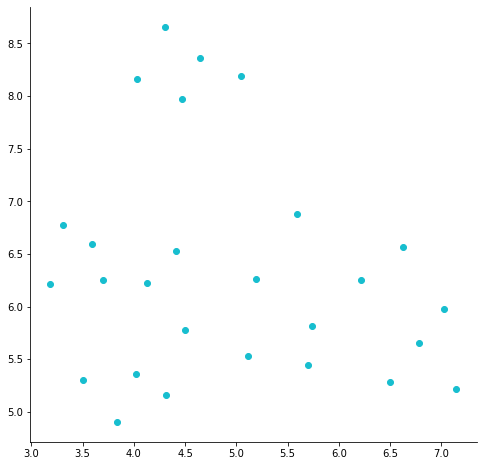

In [117]:
color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
for cluster_number in np.unique(clus.labels_):
    cluster_mask = clus.labels_ == cluster_number
    plt.plot(embedding[cluster_mask, 0], embedding[cluster_mask,1], '.', color=color_cycle[cluster_number], ms=12)
sns.despine()
plt.gcf().set_size_inches(8, 8)

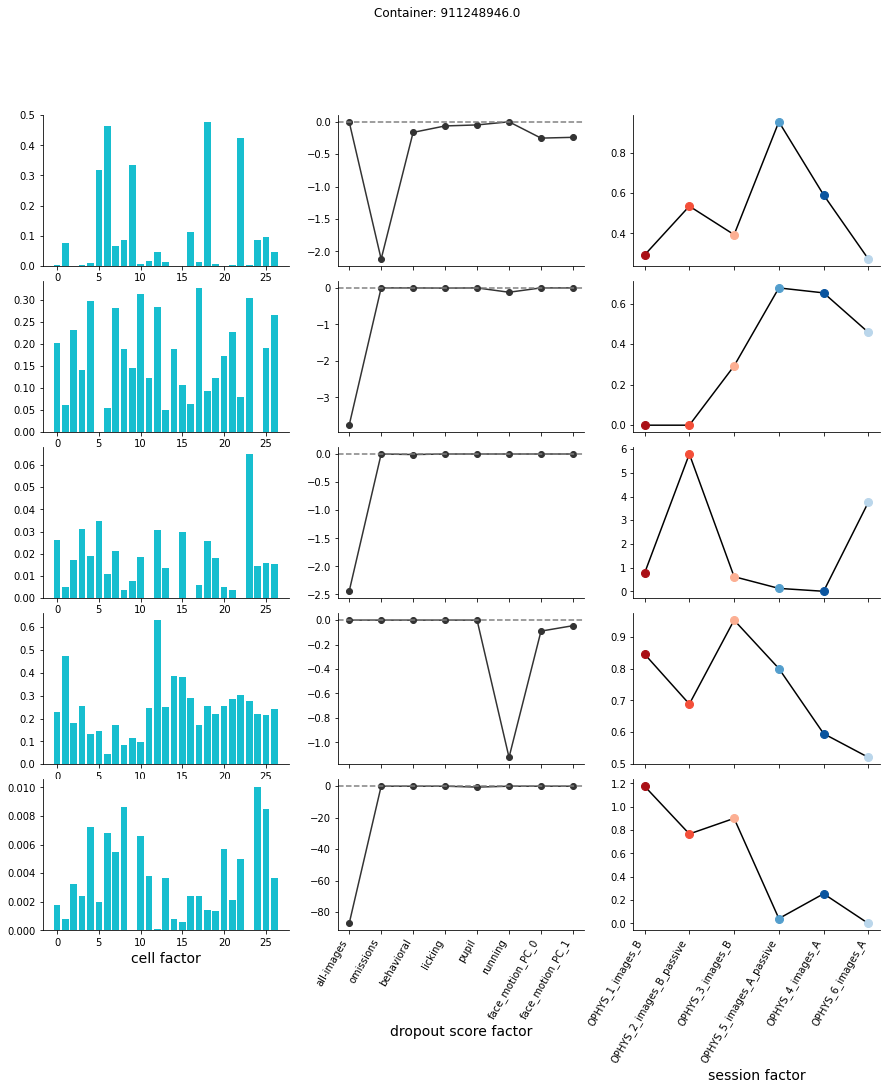

In [118]:
tca.container_tca_plot(cluster_labels=clus.labels_)

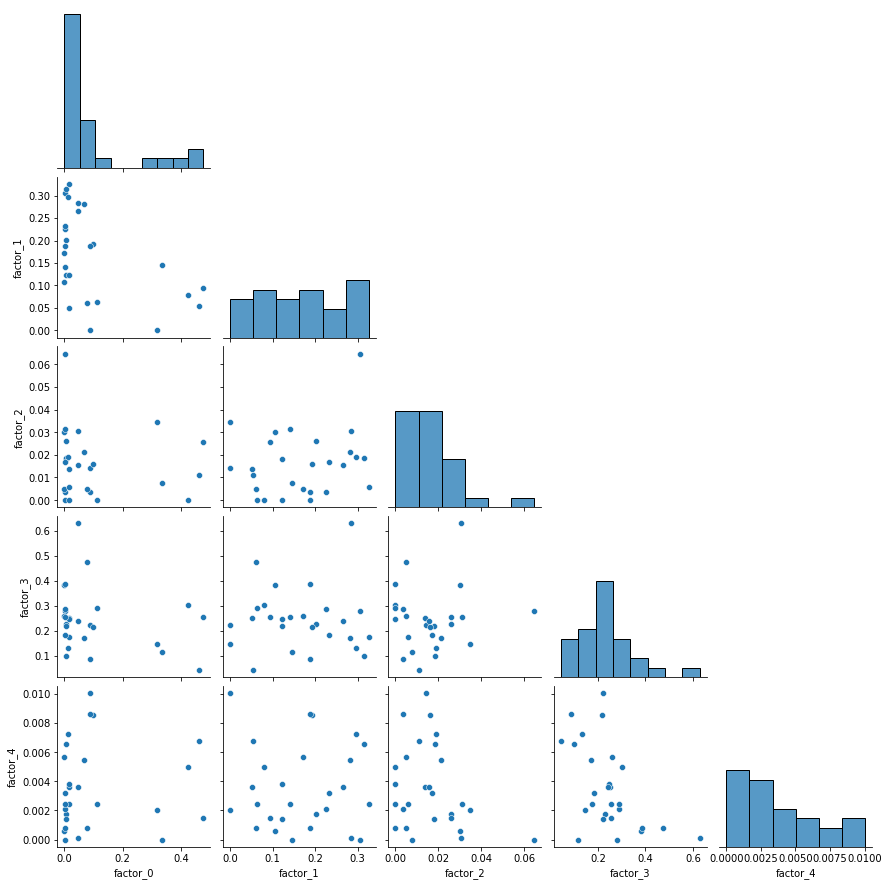

In [119]:
tca.all_cell_factor_correlation_plot()

# VIP containers

In [120]:
container_id = vip_containers_sorted_by_average_number_of_cells.index[0]
container_id

1022731527.0

In [121]:
tca = ContainerTCA(container_id=container_id, rspm=rspm, features=clustering_features)

NCP_HALS: iteration 1, objective 0.4168947845764859, improvement inf.
NCP_HALS: iteration 2, objective 0.3366934535091152, improvement 0.08020133106737065.
NCP_HALS: iteration 3, objective 0.3179636356241457, improvement 0.018729817884969524.
NCP_HALS: iteration 4, objective 0.3121651043807157, improvement 0.005798531243429994.
NCP_HALS: iteration 5, objective 0.3088900015382263, improvement 0.0032751028424893858.
NCP_HALS: iteration 6, objective 0.3064213685238652, improvement 0.0024686330143611213.
NCP_HALS: iteration 7, objective 0.304356692009419, improvement 0.0020646765144461954.
NCP_HALS: iteration 8, objective 0.30279837909473994, improvement 0.0015583129146790609.
NCP_HALS: iteration 9, objective 0.3017381943988223, improvement 0.0010601846959176209.
NCP_HALS: iteration 10, objective 0.30082065892953946, improvement 0.0009175354692828597.
NCP_HALS: iteration 11, objective 0.29995383845844187, improvement 0.0008668204710975957.
NCP_HALS: iteration 12, objective 0.29932523203309

In [122]:
reducer = umap.UMAP()
cell_fac_df = tca.get_factor_df(factor='cell')
embedding = reducer.fit_transform(cell_fac_df.values)
embedding.shape

/home/nick.ponvert/.conda/envs/nick/lib/python3.7/site-packages/umap/umap_.py:1679: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  "n_neighbors is larger than the dataset size; truncating to "


(9, 2)

In [123]:
clus = DBSCAN(eps=0.54, min_samples=5).fit(embedding)

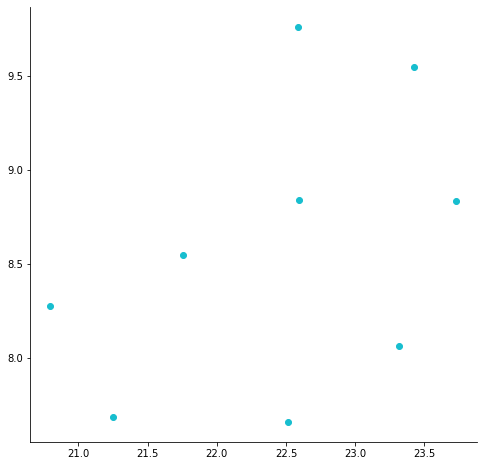

In [124]:
color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
for cluster_number in np.unique(clus.labels_):
    cluster_mask = clus.labels_ == cluster_number
    plt.plot(embedding[cluster_mask, 0], embedding[cluster_mask,1], '.', color=color_cycle[cluster_number], ms=12)
sns.despine()
plt.gcf().set_size_inches(8, 8)

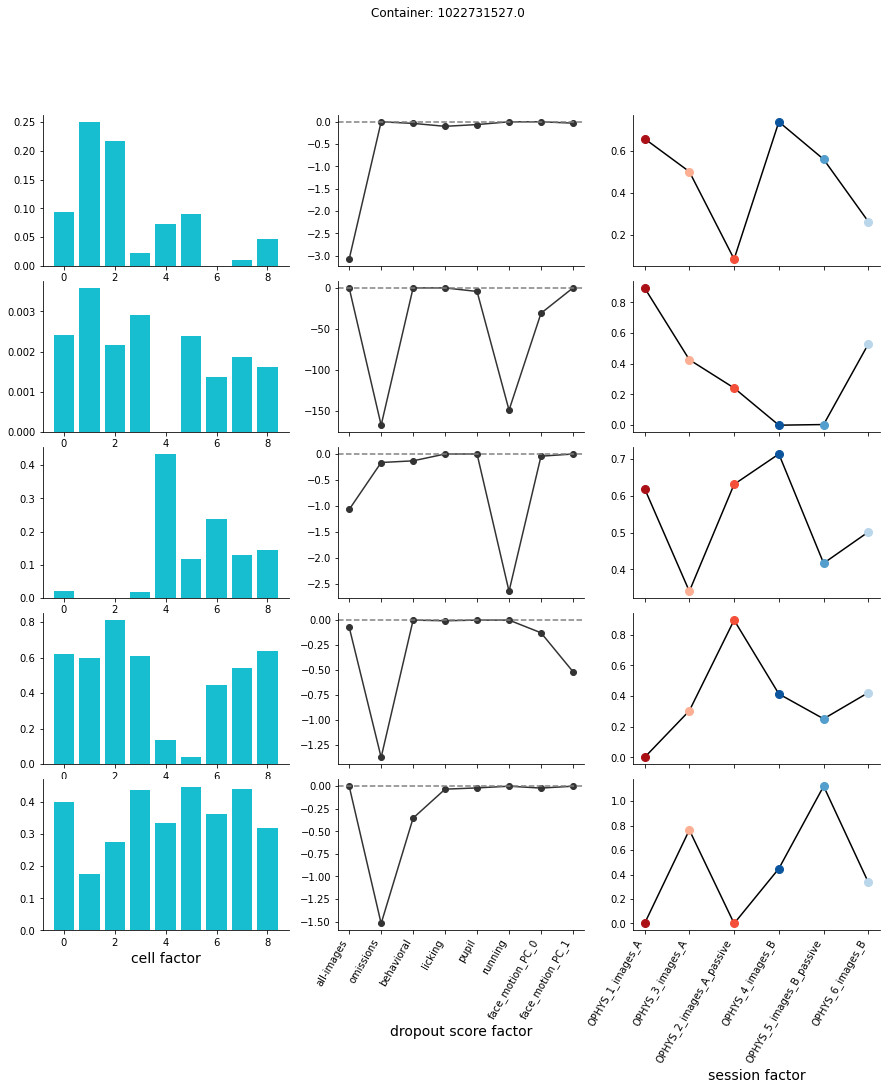

In [125]:
tca.container_tca_plot(cluster_labels=clus.labels_)

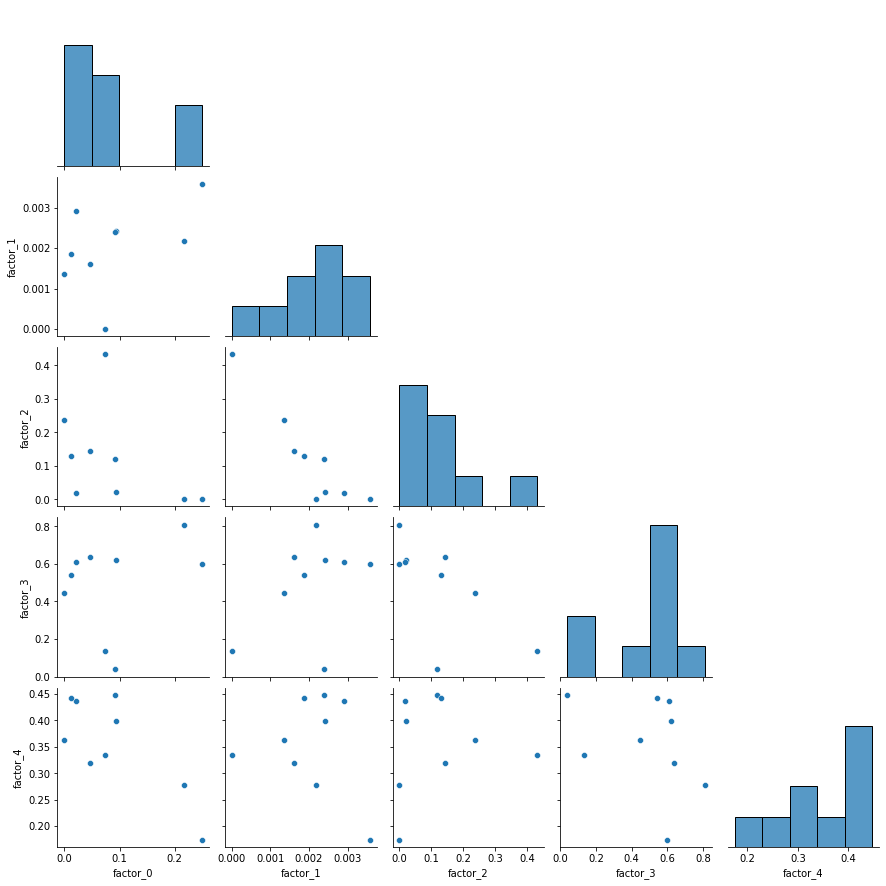

In [126]:
tca.all_cell_factor_correlation_plot()

---

In [127]:
container_id = vip_containers_sorted_by_average_number_of_cells.index[1]
container_id

791352433.0

In [128]:
tca = ContainerTCA(container_id=container_id, rspm=rspm, features=clustering_features)

NCP_HALS: iteration 1, objective 0.4254569320804841, improvement inf.
NCP_HALS: iteration 2, objective 0.35146114508951937, improvement 0.07399578699096471.
NCP_HALS: iteration 3, objective 0.3291852547641282, improvement 0.02227589032539118.
NCP_HALS: iteration 4, objective 0.3168516792794609, improvement 0.012333575484667292.
NCP_HALS: iteration 5, objective 0.3104030948154902, improvement 0.006448584463970675.
NCP_HALS: iteration 6, objective 0.30670237930962974, improvement 0.0037007155058604857.
NCP_HALS: iteration 7, objective 0.30433694750228923, improvement 0.002365431807340501.
NCP_HALS: iteration 8, objective 0.30277439633703424, improvement 0.0015625511652549995.
NCP_HALS: iteration 9, objective 0.30184790470982864, improvement 0.0009264916272055945.
NCP_HALS: iteration 10, objective 0.3012796607112622, improvement 0.00056824399856642.
NCP_HALS: iteration 11, objective 0.3009464954542027, improvement 0.00033316525705950895.
NCP_HALS: iteration 12, objective 0.300719163800879

In [129]:
reducer = umap.UMAP()
cell_fac_df = tca.get_factor_df(factor='cell')
embedding = reducer.fit_transform(cell_fac_df.values)
embedding.shape

/home/nick.ponvert/.conda/envs/nick/lib/python3.7/site-packages/umap/umap_.py:1679: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  "n_neighbors is larger than the dataset size; truncating to "


(5, 2)

In [130]:
clus = DBSCAN(eps=0.54, min_samples=5).fit(embedding)

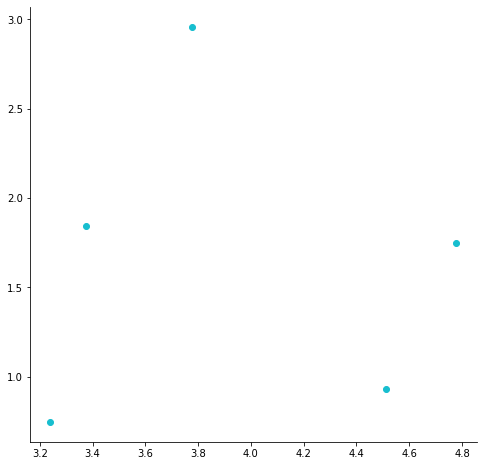

In [131]:
color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
for cluster_number in np.unique(clus.labels_):
    cluster_mask = clus.labels_ == cluster_number
    plt.plot(embedding[cluster_mask, 0], embedding[cluster_mask,1], '.', color=color_cycle[cluster_number], ms=12)
sns.despine()
plt.gcf().set_size_inches(8, 8)

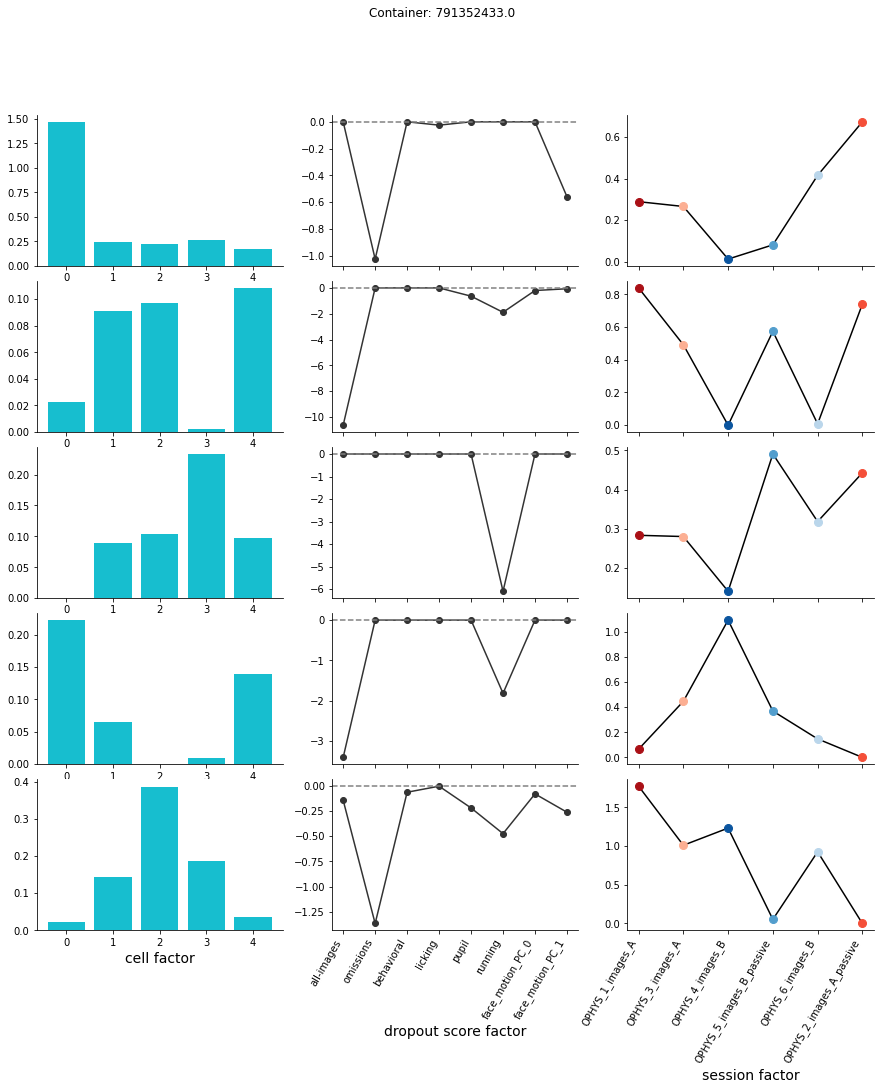

In [132]:
tca.container_tca_plot(cluster_labels=clus.labels_)

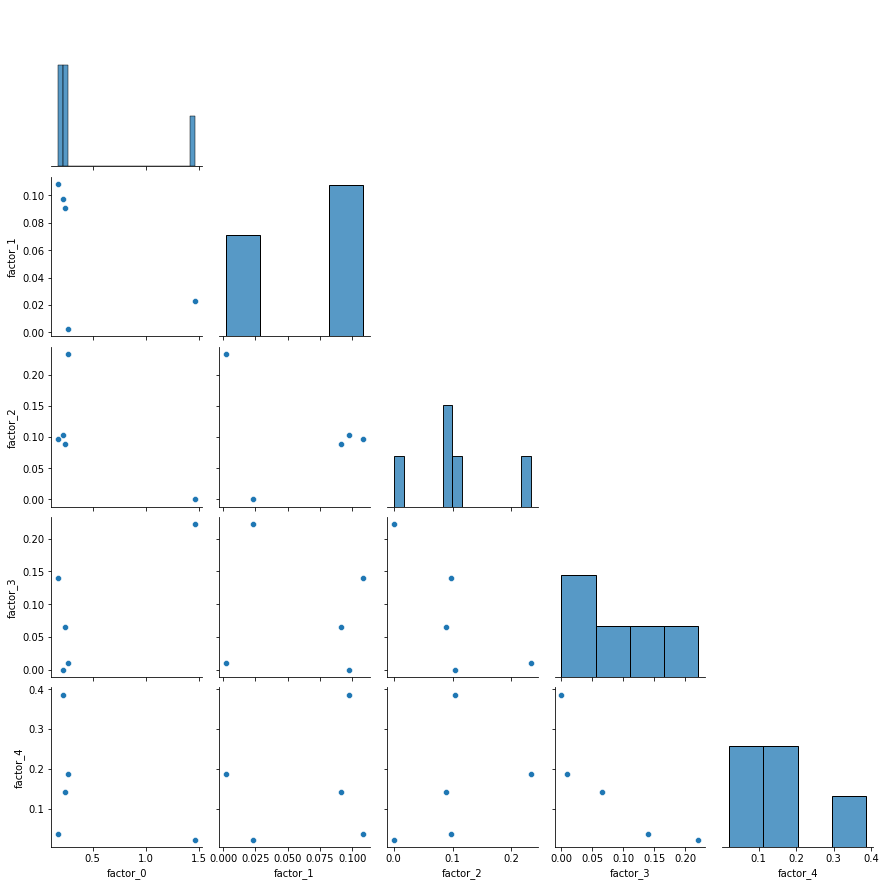

In [133]:
tca.all_cell_factor_correlation_plot()